## This is notebook for putting all the models so far in a nice format and making plots for the final presentations
#### Version 2.0 by YY on Dec 9th 2023

### Import libraries and packages

In [35]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import time

### Device managment

In [36]:
# For CoLab or Nvdia device, run this cell
device = 'cuda' if torch.cuda.is_available() else 'cpu' # using gpu or cpu
print(device)

cuda


In [23]:
# For Macbook M series chipset, use MPS instead, run this cell

# Check that MPS is available
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available")
    else:
        print("MPS not available")
else:
    device = torch.device("mps")
print(device)

mps


### Data import

In [44]:
# Import data
### For google Colab
#filepath = '/content/drive/MyDrive/Colab Notebooks/Project/'

### For Macbook of YY
#filepath = '/Users/yorkie/Desktop/CISC684/Project/'
### For windows of YY
filepath = 'C:/Users/Yinkui/Desktop/CS684/Project/'


dataset = pd.read_csv(os.path.join(filepath, 'train.csv'),names=['Store','Dept','Date','weeklySales','isHoliday'],sep=',', header=0)
dataset['Date'] = pd.to_datetime(dataset['Date'])
print(dataset.head(5))

features = pd.read_csv(os.path.join(filepath, 'features.csv'),sep=',', header=0,
                       names=['Store','Date','Temperature','Fuel_Price','MarkDown1','MarkDown2','MarkDown3','MarkDown4',
                              'MarkDown5','CPI','Unemployment','IsHoliday']).drop(columns=['IsHoliday'])
features['Date'] = pd.to_datetime(features['Date'])
#features['Temperature_norm'] = features['Temperature'].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
features['Temperature_norm'] = (features['Temperature'] - features['Temperature'].min()) / (features['Temperature'].max() - features['Temperature'].min())
features['Fuel_Price_norm'] = (features['Fuel_Price'] - features['Fuel_Price'].min()) / (features['Fuel_Price'].max() - features['Fuel_Price'].min())
features['CPI_norm'] = (features['CPI'] - features['CPI'].min()) / (features['CPI'].max() - features['CPI'].min())
features['Unemployment_norm'] = (features['Unemployment'] - features['Unemployment'].min()) / (features['Unemployment'].max() - features['Unemployment'].min())

print(features.head(5))

stores = pd.read_csv(os.path.join(filepath, 'stores.csv'), names=['Store','Type','Size'],sep=',', header=0)
stores['Size_norm'] = (stores['Size'] - stores['Size'].min()) / (stores['Size'].max() - stores['Size'].min())

min_value = dataset['weeklySales'].min()  # Store the minimum value
max_value = dataset['weeklySales'].max()  # Store the maximum value


print(min_value)
print(max_value)


   Store  Dept       Date  weeklySales  isHoliday
0      1     1 2010-02-05     24924.50      False
1      1     1 2010-02-12     46039.49       True
2      1     1 2010-02-19     41595.55      False
3      1     1 2010-02-26     19403.54      False
4      1     1 2010-03-05     21827.90      False
   Store       Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  MarkDown3  \
0      1 2010-02-05        42.31       2.572        NaN        NaN        NaN   
1      1 2010-02-12        38.51       2.548        NaN        NaN        NaN   
2      1 2010-02-19        39.93       2.514        NaN        NaN        NaN   
3      1 2010-02-26        46.63       2.561        NaN        NaN        NaN   
4      1 2010-03-05        46.50       2.625        NaN        NaN        NaN   

   MarkDown4  MarkDown5         CPI  Unemployment  Temperature_norm  \
0        NaN        NaN  211.096358         8.106          0.454046   
1        NaN        NaN  211.242170         8.106          0.419260   


In [38]:
scaler = MinMaxScaler(feature_range=(-1, 1))
dataset['weeklySales'] = scaler.fit_transform(dataset['weeklySales'].values.reshape(-1,1))

print(dataset['weeklySales'])
print('weeklySales.shape = ', dataset['weeklySales'].shape)

0        -0.914299
1        -0.853805
2        -0.866537
3        -0.930116
4        -0.923171
            ...   
421565   -0.984250
421566   -0.983907
421567   -0.982667
421568   -0.983529
421569   -0.982622
Name: weeklySales, Length: 421570, dtype: float64
weeklySales.shape =  (421570,)


In [39]:
lookback = 5
#dataset['Week'] = dataset.Date.dt.isocalendar().week
lead_5 = dataset.groupby(['Store','Dept'])[['Store', 'Dept', 'weeklySales']].shift(-lookback)
lead_4 = dataset.groupby(['Store','Dept'])[['Store', 'Dept', 'weeklySales']].shift(-lookback + 1)
lead_3 = dataset.groupby(['Store','Dept'])[['Store', 'Dept', 'weeklySales']].shift(-lookback + 2)
lead_2 = dataset.groupby(['Store','Dept'])[['Store', 'Dept', 'weeklySales']].shift(-lookback + 3)
lead_1 = dataset.groupby(['Store','Dept'])[['Store', 'Dept', 'weeklySales']].shift(-lookback + 4)


dataset['weeklySales_5'] = lead_5['weeklySales']
dataset['weeklySales_4'] = lead_4['weeklySales']
dataset['weeklySales_3'] = lead_3['weeklySales']
dataset['weeklySales_2'] = lead_2['weeklySales']
dataset['weeklySales_1'] = lead_1['weeklySales']

In [40]:
# Merge data
raw = dataset.merge(stores, how='left').merge(features, how='left')
raw = raw.dropna(subset = ['weeklySales','weeklySales_5','weeklySales_1','weeklySales_3','weeklySales_4','weeklySales_2'])
print(raw.head(5))

   Store  Dept       Date  weeklySales  isHoliday  weeklySales_5  \
0      1     1 2010-02-05    -0.914299      False      -0.925418   
1      1     1 2010-02-12    -0.853805       True      -0.922286   
2      1     1 2010-02-19    -0.866537      False      -0.910561   
3      1     1 2010-02-26    -0.930116      False      -0.821663   
4      1     1 2010-03-05    -0.923171      False      -0.862625   

   weeklySales_4  weeklySales_3  weeklySales_2  weeklySales_1  ... MarkDown2  \
0      -0.923171      -0.930116      -0.866537      -0.853805  ...       NaN   
1      -0.925418      -0.923171      -0.930116      -0.866537  ...       NaN   
2      -0.922286      -0.925418      -0.923171      -0.930116  ...       NaN   
3      -0.910561      -0.922286      -0.925418      -0.923171  ...       NaN   
4      -0.821663      -0.910561      -0.922286      -0.925418  ...       NaN   

   MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  \
0        NaN        NaN        NaN  211.096358

In [41]:
# Data Managment

raw['Week'] = raw.Date.dt.isocalendar().week
raw['Month'] = raw.Date.dt.month
raw['Year'] = raw.Date.dt.year
#raw['Year_Week'] = str(raw['Year']) + ' - ' + str(raw['Month'])

# Derived from a scatterplot of avg weekly sales by department
raw['Dept_Group1_Ind'] = np.where(raw['Dept'].isin([38, 95, 92]), 1, 0)
raw['Dept_Group2_Ind'] = np.where(raw['Dept'].isin([65, 2, 40, 90, 72]), 1, 0)
raw['Dept_Group3_Ind'] = np.where(~raw['Dept'].isin([38, 95, 92, 65, 2, 40, 90, 72]), 1, 0)
#print(raw[raw['Dept_Group3_Ind'] == 1]['Dept'].unique())

conditions = [
    raw['Size'] < 100000,
    (raw['Size'] >= 100000) & (raw['Size'] < 175000),
    raw['Size'] >= 175000
]
choices = ["Small", "Medium", "Large"]
raw['Size_Group'] = np.select(conditions, choices)

raw['CPI_Group'] = raw['CPI'].apply(lambda x: 1 if x < 160 else 0)
raw['Unemployment_Group'] = raw['Unemployment'].apply(lambda x: 1 if x < 5 else 0)


raw['MarkDown1_Ind'] = raw['MarkDown1'].apply(lambda x: 0 if pd.isna(x) else 1)
raw['MarkDown2_Ind'] = raw['MarkDown2'].apply(lambda x: 0 if pd.isna(x) else 1)
raw['MarkDown3_Ind'] = raw['MarkDown3'].apply(lambda x: 0 if pd.isna(x) else 1)
raw['MarkDown4_Ind'] = raw['MarkDown4'].apply(lambda x: 0 if pd.isna(x) else 1)
raw['MarkDown5_Ind'] = raw['MarkDown5'].apply(lambda x: 0 if pd.isna(x) else 1)
raw['Holiday_Ind'] = raw['isHoliday'].apply(lambda x: 0 if x == 0 else 1)

raw['CPI_Round'] = raw['CPI'].round(decimals=0)
raw['Unemployment_Round'] = raw['Unemployment'].round(decimals=0)

raw['ThanksGiving_Ind'] = np.where((raw['Week'] == 47), 1, 0)
raw['Chistmas_1_Ind'] = np.where((raw['Week'] == 49) , 1, 0)
raw['Chistmas_2_Ind'] = np.where((raw['Week'] == 50), 1, 0)
raw['Chistmas_3_Ind'] = np.where((raw['Week'] == 51), 1, 0)

raw['Last_Year'] = raw['Year'] - 1

raw['Holiday_loss'] = np.where((raw['Holiday_Ind'] == 1) , 5, 1)





In [42]:
# split to training dataset and validation dataset

raw_train = pd.get_dummies(raw, columns=['Store', 'Dept', 'Week', 'Type','Size_Group'])
raw_train['Store'] = raw['Store']
raw_train['Dept'] = raw['Dept']
raw_train['Week'] = raw['Week']
raw_train['Type'] = raw['Type']

train = raw_train[raw_train['Year'] > 2010]
vldt = raw_train[raw_train['Year'] == 2010]

#print(vldt['Holiday_Ind'])

pd.DataFrame(train.dtypes, columns=['Type'])

,Type
Date,datetime64[ns]
weeklySales,float64
isHoliday,bool
weeklySales_5,float64
weeklySales_4,float64
...,...
Size_Group_Small,bool
Store,int64
Dept,int64
Week,UInt32


In [10]:
columns = list(train.columns)
print(columns)
print(train['Holiday_loss'])

['Date', 'weeklySales', 'isHoliday', 'weeklySales_5', 'weeklySales_4', 'weeklySales_3', 'weeklySales_2', 'weeklySales_1', 'Size', 'Size_norm', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Temperature_norm', 'Fuel_Price_norm', 'CPI_norm', 'Unemployment_norm', 'Month', 'Year', 'Dept_Group1_Ind', 'Dept_Group2_Ind', 'Dept_Group3_Ind', 'CPI_Group', 'Unemployment_Group', 'MarkDown1_Ind', 'MarkDown2_Ind', 'MarkDown3_Ind', 'MarkDown4_Ind', 'MarkDown5_Ind', 'Holiday_Ind', 'CPI_Round', 'Unemployment_Round', 'ThanksGiving_Ind', 'Chistmas_1_Ind', 'Chistmas_2_Ind', 'Chistmas_3_Ind', 'Last_Year', 'Holiday_loss', 'Store_1', 'Store_2', 'Store_3', 'Store_4', 'Store_5', 'Store_6', 'Store_7', 'Store_8', 'Store_9', 'Store_10', 'Store_11', 'Store_12', 'Store_13', 'Store_14', 'Store_15', 'Store_16', 'Store_17', 'Store_18', 'Store_19', 'Store_20', 'Store_21', 'Store_22', 'Store_23', 'Store_24', 'Store_25', 'Store_26', 'Store_27', 'Store

## Model 1: Linear regression (One-hot)

This model is with modified features.

In [11]:
# Data Management
columns = list(train.columns)
print(columns)


['Date', 'weeklySales', 'isHoliday', 'weeklySales_5', 'weeklySales_4', 'weeklySales_3', 'weeklySales_2', 'weeklySales_1', 'Size', 'Size_norm', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Temperature_norm', 'Fuel_Price_norm', 'CPI_norm', 'Unemployment_norm', 'Month', 'Year', 'Dept_Group1_Ind', 'Dept_Group2_Ind', 'Dept_Group3_Ind', 'CPI_Group', 'Unemployment_Group', 'MarkDown1_Ind', 'MarkDown2_Ind', 'MarkDown3_Ind', 'MarkDown4_Ind', 'MarkDown5_Ind', 'Holiday_Ind', 'CPI_Round', 'Unemployment_Round', 'ThanksGiving_Ind', 'Chistmas_1_Ind', 'Chistmas_2_Ind', 'Chistmas_3_Ind', 'Last_Year', 'Holiday_loss', 'Store_1', 'Store_2', 'Store_3', 'Store_4', 'Store_5', 'Store_6', 'Store_7', 'Store_8', 'Store_9', 'Store_10', 'Store_11', 'Store_12', 'Store_13', 'Store_14', 'Store_15', 'Store_16', 'Store_17', 'Store_18', 'Store_19', 'Store_20', 'Store_21', 'Store_22', 'Store_23', 'Store_24', 'Store_25', 'Store_26', 'Store_27', 'Store

In [94]:
#df = train[columns[1:3, 206:208]]
df1 = train.loc[:, 'Store_1':'Type_C']
df2 = train.loc[:, 'Size_norm':'Size_norm']
df3 = train.loc[:, 'Temperature_norm':'Unemployment_norm']
df4 = train.loc[:, 'MarkDown1_Ind':'Holiday_Ind']
df5 = train.loc[:,'weeklySales_5':'weeklySales_1']
df6 = train.loc[:, 'ThanksGiving_Ind':'Chistmas_3_Ind']
X = np.concatenate((df1, df2, df3, df4, df5,df6), axis=1)
y = np.array(train['weeklySales'])

print(X.shape)
print(y.shape)

print(X.shape[1])

print(type(X))
print(type(y))

(264748, 201)
(264748,)
201
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [95]:
from sklearn import linear_model
reg_sklearn = linear_model.LinearRegression()
reg_sklearn.fit(X, y)

LinearRegression()

In [103]:
# Train the model
y_pred = reg_sklearn.predict(X)
y_pred  = (y_pred+1)/2*(max_value - min_value) +min_value
train1 = train.copy()
train1['y_pred_1hot'] = y_pred
train1['weeklySales'] = (train1['weeklySales']+1)/2*(max_value - min_value) +min_value
# Print training loss defined by the project requirment
print("Training error is: "+str(np.mean(np.absolute(train1['weeklySales']-train1['y_pred_1hot'])*train1['Holiday_loss'])))

Training error is: 2893.0884673539363


In [105]:
#df = train[columns[1:3, 206:208]]
df1 = vldt.loc[:, 'Store_1':'Type_C']
df2 = vldt.loc[:, 'Size_norm':'Size_norm']
df3 = vldt.loc[:, 'Temperature_norm':'Unemployment_norm']
df4 = vldt.loc[:, 'MarkDown1_Ind':'Holiday_Ind']
df5 = vldt.loc[:,'weeklySales_5':'weeklySales_1']
df6 = vldt.loc[:, 'ThanksGiving_Ind':'Chistmas_3_Ind']
X_vldt = np.concatenate((df1, df2, df3, df4, df5,df6), axis=1)
y_vldt = np.array(vldt['weeklySales'])


#Test the model
y_vldt_pred = reg_sklearn.predict(X_vldt)
y_vldt_pred  = (y_vldt_pred+1)/2*(max_value - min_value) +min_value
vldt1 = vldt.copy()
vldt1['y_vldt_pred'] = y_vldt_pred
vldt1['weeklySales']  = (vldt1['weeklySales']+1)/2*(max_value - min_value) +min_value
# Print testing loss defined by the project requirment
print("Testing error is: "+str(np.mean(np.absolute(vldt1['weeklySales']-vldt1['y_vldt_pred'])*vldt1['Holiday_loss'])))

Testing error is: 3585.0487432303494


<module 'matplotlib.pyplot' from 'C:\\Users\\Yinkui\\anaconda3\\Lib\\site-packages\\matplotlib\\pyplot.py'>

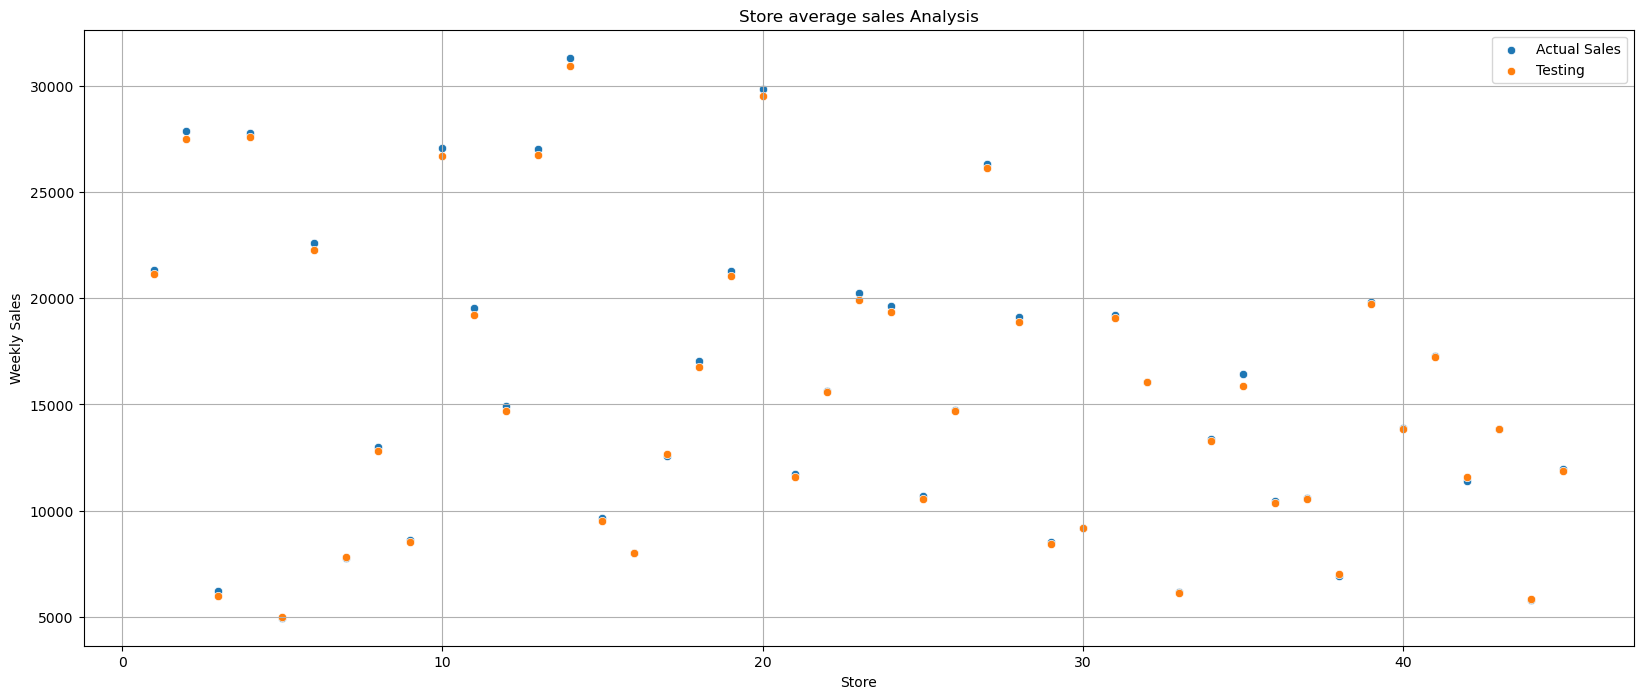

In [106]:
vldt1_grouped = vldt1.groupby(['Store'])[['weeklySales','y_vldt_pred']].mean()
train1_grouped = train1.groupby(['Store'])[['weeklySales','y_pred_1hot']].mean()
#print(vldt_grouped.head(5))

plt.figure(figsize=(20,8))

# Plot for Actual Sales in train_grouped
sns.scatterplot(x=vldt1_grouped.index, y=vldt1_grouped['weeklySales'], label='Actual Sales')

# Plot for Training (y_pred) in train_grouped
#sns.scatterplot(x=train1_grouped.index, y=train1_grouped['y_pred_1hot'], label='Training')

# Plot for Testing (y_vldt_pred) in vldt_grouped
sns.scatterplot(x=vldt1_grouped.index, y=vldt1_grouped['y_vldt_pred'], label='Testing')
#plt.xticks(np.arange(34875, 53, step=1))
plt.xlabel('Store')
plt.ylabel('Weekly Sales')
plt.title('Store average sales Analysis')
plt.grid()
plt

#Show average store sells prediction

<module 'matplotlib.pyplot' from 'C:\\Users\\Yinkui\\anaconda3\\Lib\\site-packages\\matplotlib\\pyplot.py'>

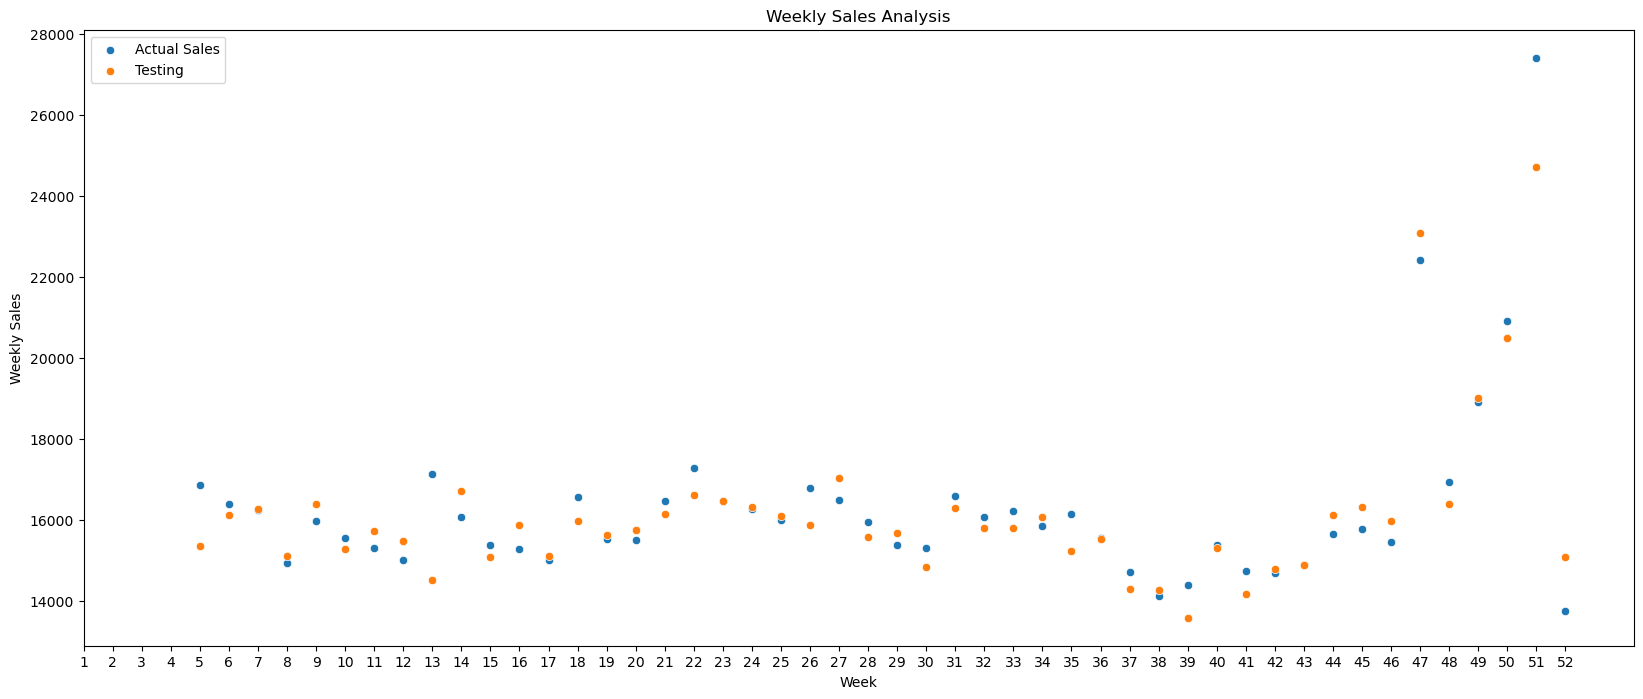

In [107]:
train1_grouped2 = train1.groupby(['Week'])[['weeklySales','y_pred_1hot']].mean()
#print(train_grouped.head(5))
vldt1_grouped2 = vldt1.groupby(['Week'])[['weeklySales','y_vldt_pred']].mean()
#print(vldt_grouped.head(5))


plt.figure(figsize=(20,8))
# Plot for Actual Sales in train_grouped
sns.scatterplot(x=vldt1_grouped2.index, y=vldt1_grouped2['weeklySales'], label='Actual Sales')

# Plot for Training (y_pred) in train_grouped
#sns.scatterplot(x=train1_grouped2.index, y=train1_grouped2['y_pred_1hot'], label='Training')

# Plot for Testing (y_vldt_pred) in vldt_grouped
sns.scatterplot(x=vldt1_grouped2.index, y=vldt1_grouped2['y_vldt_pred'], label='Testing')

# Setting the labels and title
plt.xlabel('Week')
plt.ylabel('Weekly Sales')
plt.title('Weekly Sales Analysis')
plt.grid()

plt.grid()
plt.xticks(np.arange(1, 53, step=1))
plt

## Model 2: linear regression (Grouped customized features)

In [14]:
#df = train[columns[1:3, 206:208]]
df1 = train.loc[:, 'Dept_Group1_Ind':'MarkDown5_Ind']
df2 = train.loc[:, 'ThanksGiving_Ind':'Chistmas_3_Ind']
df3 = train.loc[:, 'Type_A':'Size_Group_Small']
df4 = train.loc[:, 'Temperature_norm':'Fuel_Price_norm']

X = np.concatenate((df1, df2, df3, df4), axis=1)
y = np.array(train['weeklySales'])

print(X.shape)
print(y.shape)

print(X.shape[1])

print(type(X))
print(type(y))

(264748, 22)
(264748,)
22
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [15]:
from sklearn import linear_model
reg_sklearn = linear_model.LinearRegression()
reg_sklearn.fit(X, y)

LinearRegression()

In [16]:
# Train the model
y_pred = reg_sklearn.predict(X)
train2 = train.copy()
train2['y_pred'] = y_pred
# Print training loss defined by the project requirment
print("Training error is: "+str(np.mean(np.absolute(train2['weeklySales']-train2['y_pred'])*train2['Holiday_loss'])))

Training error is: 14088.453639007663


In [17]:

df1 = vldt.loc[:, 'Dept_Group1_Ind':'MarkDown5_Ind']
df2 = vldt.loc[:, 'ThanksGiving_Ind':'Chistmas_3_Ind']
df3 = vldt.loc[:, 'Type_A':'Size_Group_Small']
df4 = vldt.loc[:, 'Temperature_norm':'Fuel_Price_norm']
X_vldt = np.concatenate((df1, df2, df3, df4), axis=1)
#Test the model
y_vldt_pred = reg_sklearn.predict(X_vldt)
vldt2 = vldt.copy()
vldt2['y_vldt_pred'] = y_vldt_pred

# Print testing loss defined by the project requirment
print("Testing error is: "+str(np.mean(np.absolute(vldt2['weeklySales']-vldt2['y_vldt_pred'])*vldt2['Holiday_loss'])))

Testing error is: 15334.19750300795


<module 'matplotlib.pyplot' from 'C:\\Users\\Yinkui\\anaconda3\\Lib\\site-packages\\matplotlib\\pyplot.py'>

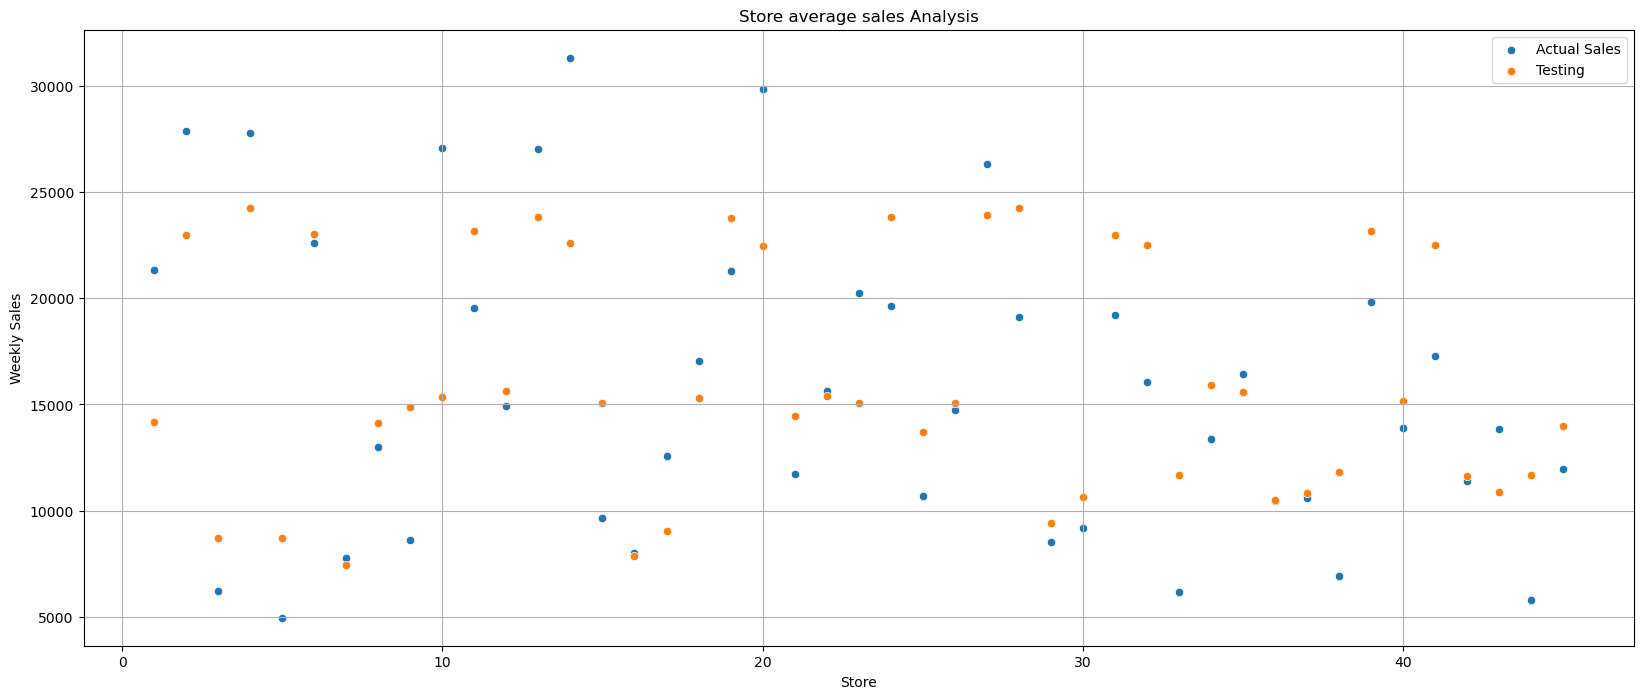

In [18]:
vldt2_grouped = vldt2.groupby(['Store'])[['weeklySales','y_vldt_pred']].mean()
train2_grouped = train2.groupby(['Store'])[['weeklySales','y_pred']].mean()
#print(vldt_grouped.head(5))

plt.figure(figsize=(20,8))

# Plot for Actual Sales in train_grouped
sns.scatterplot(x=vldt2_grouped.index, y=vldt2_grouped['weeklySales'], label='Actual Sales')

# Plot for Training (y_pred) in train_grouped
#sns.scatterplot(x=train2_grouped.index, y=train2_grouped['y_pred'], label='Training')

# Plot for Testing (y_vldt_pred) in vldt_grouped
sns.scatterplot(x=vldt2_grouped.index, y=vldt2_grouped['y_vldt_pred'], label='Testing')
#plt.xticks(np.arange(34875, 53, step=1))
plt.xlabel('Store')
plt.ylabel('Weekly Sales')
plt.title('Store average sales Analysis')
plt.grid()
plt

#Show average store sells prediction

<module 'matplotlib.pyplot' from 'C:\\Users\\Yinkui\\anaconda3\\Lib\\site-packages\\matplotlib\\pyplot.py'>

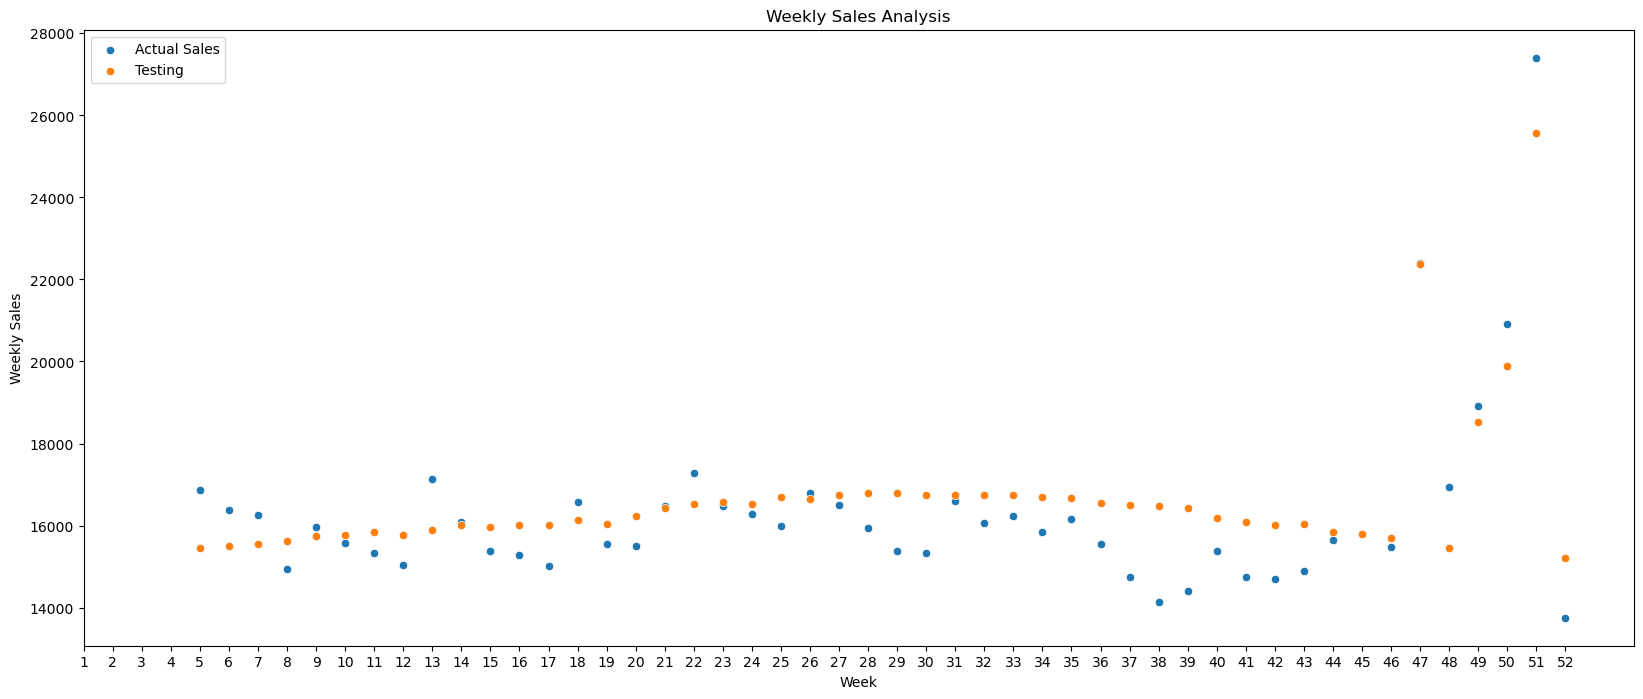

In [66]:
train2_grouped2 = train2.groupby(['Week'])[['weeklySales','y_pred']].mean()
#print(train_grouped.head(5))
vldt2_grouped2 = vldt2.groupby(['Week'])[['weeklySales','y_vldt_pred']].mean()
#print(vldt_grouped.head(5))


plt.figure(figsize=(20,8))
# Plot for Actual Sales in train_grouped
sns.scatterplot(x=vldt2_grouped2.index, y=vldt2_grouped2['weeklySales'], label='Actual Sales')

# Plot for Training (y_pred) in train_grouped
#sns.scatterplot(x=train2_grouped2.index, y=train2_grouped2['y_pred'], label='Training')

# Plot for Testing (y_vldt_pred) in vldt_grouped
sns.scatterplot(x=vldt2_grouped2.index, y=vldt2_grouped2['y_vldt_pred'], label='Testing')

# Setting the labels and title
plt.xlabel('Week')
plt.ylabel('Weekly Sales')
plt.title('Weekly Sales Analysis')
plt.grid()

plt.grid()
plt.xticks(np.arange(1, 53, step=1))
plt

## Model 3: Linear Regression with customized loss function
The features are still based on the best we have so far which is one hot encoded feature.


In [71]:
print(train['Holiday_loss'])

48        1
49        1
50        1
51        1
52        1
         ..
421560    1
421561    1
421562    5
421563    1
421564    1
Name: Holiday_loss, Length: 264748, dtype: int64


In [25]:
# Modified homework model
class LinearReg:

    def __init__(self, learning_rate=0.01, epochs=10000, lmbda=0.0):
        self.epochs = epochs # number of epochs to train
        self.lr = learning_rate # learning rate - how fast the model should be updated
        self.w = None # the weights or coefficients
        self.b = None # the bias term
        self.lmbda = lmbda # regularization coefficient
        self.cost_list = [] # cost list for plotting

    def __initial_params(self, shape):
        #initialize weigth and bias as zeros

        #### START CODE HERE (~2 line) ####
        self.w = np.zeros(shape)
        self.b = 0

        #### END CODE HERE ####

    def __predictions(self, X):
        return np.dot(X, self.w) + self.b

    def __calculate_cost(self, error):

        return np.mean(np.absolute(error)*train['Holiday_loss'])


    def __gradient_descent(self, X, y, y_pred):
        # difference between prediction and actual
        error = y_pred - y

        # calculate cost and append them to list
        cost = self.__calculate_cost(error)
        self.cost_list.append(cost)

        # Calculate gradients
        # Return:
        # dw -- gradient of the loss with respect to w, thus same shape as w
        # db -- gradient of the loss with respect to b, thus same shape as b

        ### START CODE HERE ### (≈ 3 lines of code)
        self.dw = np.matmul(X.T, error)/X.shape[0] + self.lmbda * self.w
        self.db = np.sum(error)/X.shape[0] + self.lmbda * self.b
        return self.dw, self.db
        ### END CODE HERE ###

    def __update_parameters(self, dw, db):
        #update weight and bias with gradients
        self.w -= self.lr * dw
        self.b -= self.lr * db

        return True

    def fit(self, X, y):
        """fits the model"""
        self.__initial_params(X.shape[1])
        for _ in range(self.epochs):
            y_pred = self.__predictions(X)
            dw, db,  = self.__gradient_descent(X, y, y_pred)
            self.__update_parameters(dw, db)
        return True

    def predict(self, X):
        return self.__predictions(X)

    def calculate_rmse(self, y_real, y_pred):
        """returns root mean square error"""

        ### START CODE HERE ### (≈ 1 lines of code)
        return np.sqrt(sum((y_real-y_pred)**2)/(2*X.shape[0]))
        ### END CODE HERE ###

    def get_params(self):
        return self.w, self.b

    def plot_cost(self):
        """plots the progress of cost on each iteration"""
        plt.title('Customized loss function')
        plt.xlabel('No. of iterations')
        plt.ylabel('Loss')
        plt.plot(self.cost_list)
        plt.show()

    def calculate_r2(self, X, y):
        """returns r2"""
        sum_squares = 0
        sum_residuals = 0
        y_mean = np.mean(y)
        for i in range(X.shape[0]):
            y_pred = self.__predictions(X[i])
            sum_squares += (y[i] - y_mean) ** 2
            sum_residuals += (y[i] - y_pred) ** 2
        score = 1- (sum_residuals / sum_squares)
        return score


In [108]:
#df = train[columns[1:3, 206:208]]
df1 = train.loc[:, 'Store_1':'Type_C']
df2 = train.loc[:, 'Size_norm':'Size_norm']
df3 = train.loc[:, 'Temperature_norm':'Unemployment_norm']
df4 = train.loc[:, 'MarkDown1_Ind':'Holiday_Ind']
df5 = train.loc[:,'weeklySales_5':'weeklySales_1']
df6 = train.loc[:, 'ThanksGiving_Ind':'Chistmas_3_Ind']
X = np.concatenate((df1, df2, df3, df4, df5,df6), axis=1)
y = np.array(train['weeklySales'])

print(X.shape)
print(y.shape)

print(X.shape[1])

print(type(X))
print(type(y))

(264748, 201)
(264748,)
201
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [109]:
reg = LinearReg(learning_rate=0.1,epochs=5000, lmbda=0.0)
reg.fit(X, y) # fit/train the model

# get predictions
y_pred = reg.predict(X)


In [110]:

### Reverse scaling and calculate actual loss

y_pred = (y_pred+1)/2*(max_value - min_value) +min_value



train3 = train.copy()
train3['weeklySales'] =  (train3['weeklySales'] +1)/2*(max_value - min_value) +min_value


train3['y_pred'] = y_pred

print("Training error is: "+str(np.mean(np.absolute(train3['weeklySales']-train3['y_pred'])*train3['Holiday_loss'])))

Training error is: 3425.574234202519


In [29]:

print(y_pred)
#train3 = train.copy()
#train3['y_pred'] = y_pred

#print("Training error is: "+str(np.mean(np.absolute(train3['weeklySales']-train3['y_pred'])*train3['Holiday_loss'])))

[-648231.62365653 -640377.35750387 -639617.12168917 ... -689612.20001592
 -692688.63736776 -692716.64093662]


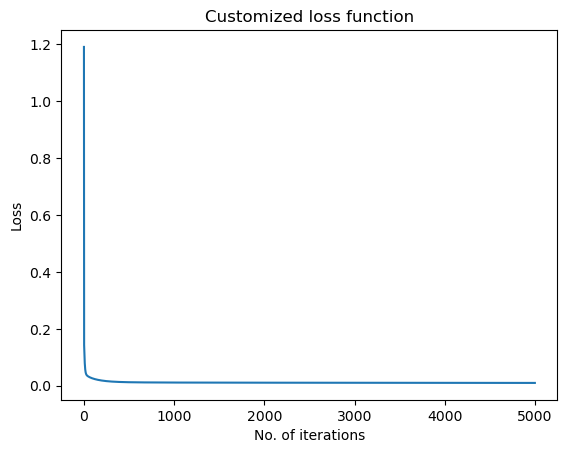

In [82]:
reg.plot_cost()

In [112]:
#df = train[columns[1:3, 206:208]]
df1 = vldt.loc[:, 'Store_1':'Type_C']
df2 = vldt.loc[:, 'Size_norm':'Size_norm']
df3 = vldt.loc[:, 'Temperature_norm':'Unemployment_norm']
df4 = vldt.loc[:, 'MarkDown1_Ind':'Holiday_Ind']
df5 = vldt.loc[:,'weeklySales_5':'weeklySales_1']
df6 = vldt.loc[:, 'ThanksGiving_Ind':'Chistmas_3_Ind']
X_vldt = np.concatenate((df1, df2, df3, df4, df5,df6), axis=1)
y_vldt = np.array(vldt['weeklySales'])

y_vldt_pred = reg.predict(X_vldt)
y_vldt_pred  = (y_vldt_pred+1)/2*(max_value - min_value) +min_value
vldt3 = vldt.copy()
vldt3['weeklySales'] = (vldt3['weeklySales']+1)/2*(max_value - min_value) +min_value
vldt3['y_vldt_pred'] = y_vldt_pred
print("Testing error is: "+str(np.mean(np.absolute(vldt3['weeklySales']-vldt3['y_vldt_pred'])*vldt3['Holiday_loss'])))


Testing error is: 4242.117893054659


<module 'matplotlib.pyplot' from 'C:\\Users\\Yinkui\\anaconda3\\Lib\\site-packages\\matplotlib\\pyplot.py'>

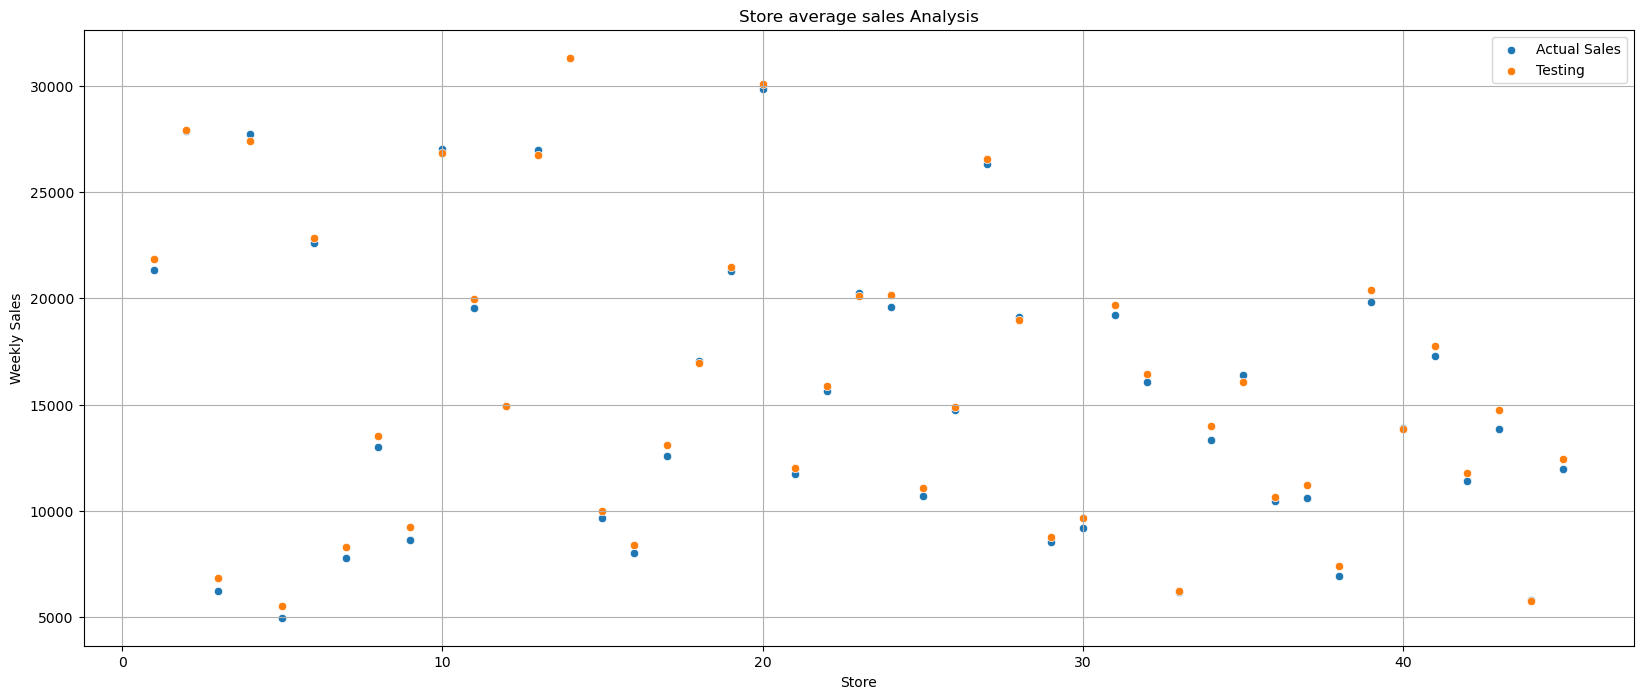

In [113]:
vldt3_grouped = vldt3.groupby(['Store'])[['weeklySales','y_vldt_pred']].mean()
train3_grouped = train3.groupby(['Store'])[['weeklySales','y_pred']].mean()
#print(vldt_grouped.head(5))

plt.figure(figsize=(20,8))

# Plot for Actual Sales in train_grouped
sns.scatterplot(x=vldt3_grouped.index, y=vldt3_grouped['weeklySales'], label='Actual Sales')

# Plot for Training (y_pred) in train_grouped
#sns.scatterplot(x=train3_grouped.index, y=train3_grouped['y_pred'], label='Training')

# Plot for Testing (y_vldt_pred) in vldt_grouped
sns.scatterplot(x=vldt3_grouped.index, y=vldt3_grouped['y_vldt_pred'], label='Testing')
#plt.xticks(np.arange(34875, 53, step=1))
plt.xlabel('Store')
plt.ylabel('Weekly Sales')
plt.title('Store average sales Analysis')
plt.grid()
plt

#Show average store sells prediction

<module 'matplotlib.pyplot' from 'C:\\Users\\Yinkui\\anaconda3\\Lib\\site-packages\\matplotlib\\pyplot.py'>

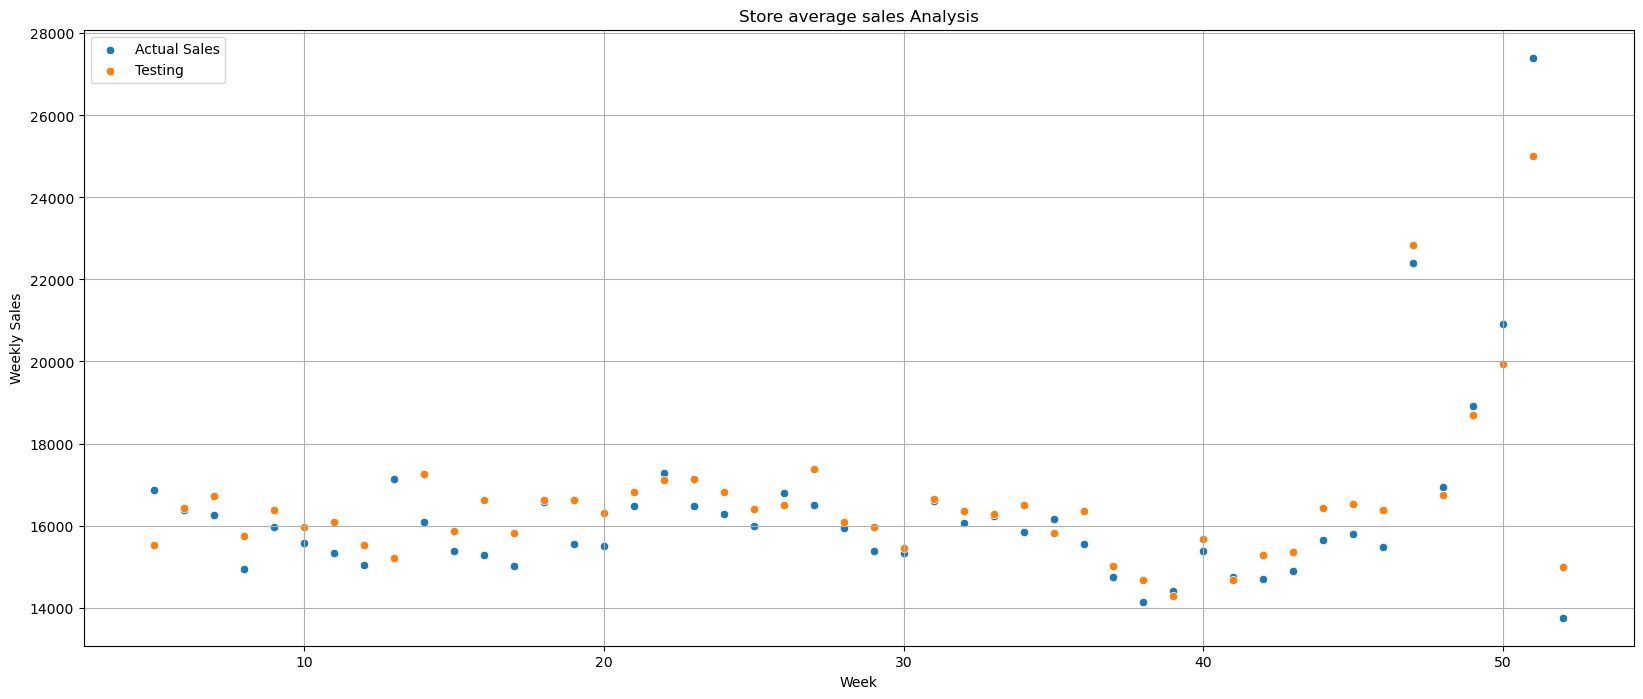

In [114]:
vldt3_grouped2 = vldt3.groupby(['Week'])[['weeklySales','y_vldt_pred']].mean()
train3_grouped2 = train3.groupby(['Week'])[['weeklySales','y_pred']].mean()
#print(vldt_grouped.head(5))

plt.figure(figsize=(20,8))

# Plot for Actual Sales in train_grouped
sns.scatterplot(x=vldt3_grouped2.index, y=vldt3_grouped2['weeklySales'], label='Actual Sales')

# Plot for Training (y_pred) in train_grouped
#sns.scatterplot(x=train3_grouped2.index, y=train3_grouped2['y_pred'], label='Training')

# Plot for Testing (y_vldt_pred) in vldt_grouped
sns.scatterplot(x=vldt3_grouped2.index, y=vldt3_grouped2['y_vldt_pred'], label='Testing')
#plt.xticks(np.arange(34875, 53, step=1))
plt.xlabel('Week')
plt.ylabel('Weekly Sales')
plt.title('Store average sales Analysis')
plt.grid()
plt

#Show average store sells prediction

## Making plot for linear regression

In [91]:
print(vldt1_grouped2['y_vldt_pred'].dtype)
print(vldt2_grouped2['y_vldt_pred'].dtype)
print(vldt3_grouped2['y_vldt_pred'].dtype)
print(vldt3_grouped2['weeklySales'].dtype)


print(vldt1_grouped2.isnull().sum())
print(vldt2_grouped2.isnull().sum())
print(vldt3_grouped2.isnull().sum())


float64
float64
float64
float64
weeklySales    0
y_vldt_pred    0
dtype: int64
weeklySales    0
y_vldt_pred    0
dtype: int64
weeklySales    0
y_vldt_pred    0
dtype: int64


In [116]:
# Convert index to datetime if it's in a recognizable date format
vldt1_grouped2.index = pd.to_datetime(vldt1_grouped2.index, errors='coerce')
vldt2_grouped2.index = pd.to_datetime(vldt2_grouped2.index, errors='coerce')
vldt3_grouped2.index = pd.to_datetime(vldt3_grouped2.index, errors='coerce')

# Check if there are any NaT (Not a Time) values which indicate conversion errors
print(vldt1_grouped2.index.isnull().sum())
print(vldt2_grouped2.index.isnull().sum())
print(vldt3_grouped2.index.isnull().sum())

# If the index is not a date, ensure it's numeric
vldt1_grouped2.index = pd.to_numeric(vldt1_grouped2.index, errors='coerce')
vldt2_grouped2.index = pd.to_numeric(vldt2_grouped2.index, errors='coerce')
vldt3_grouped2.index = pd.to_numeric(vldt3_grouped2.index, errors='coerce')

# Check again for NaN values after conversion
print(vldt1_grouped2.index.isnull().sum())
print(vldt2_grouped2.index.isnull().sum())
print(vldt3_grouped2.index.isnull().sum())


0
0
0
0
0
0


<module 'matplotlib.pyplot' from 'C:\\Users\\Yinkui\\anaconda3\\Lib\\site-packages\\matplotlib\\pyplot.py'>

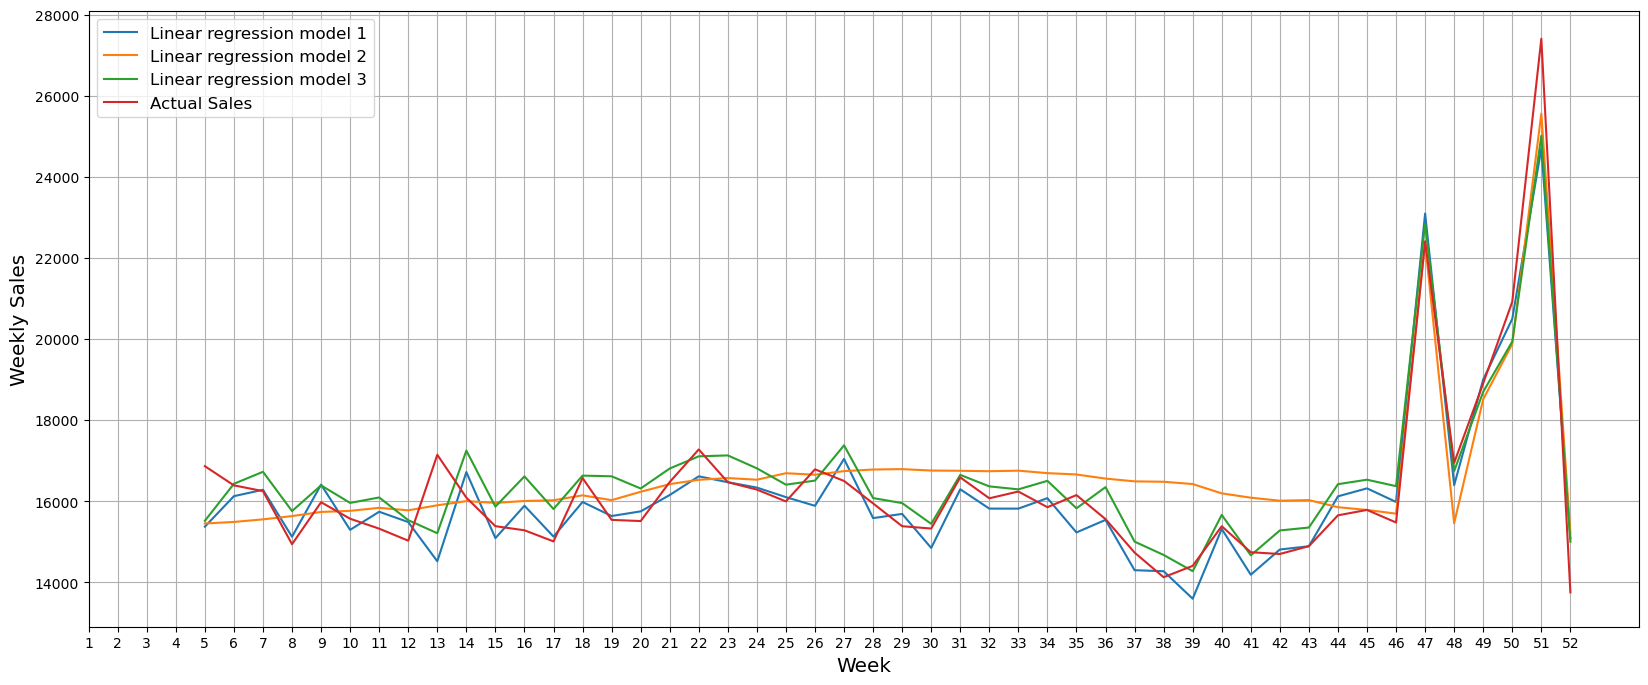

In [171]:
plt.figure(figsize=(20,8))
sns.lineplot(x=vldt1_grouped2.index, y=vldt1_grouped2['y_vldt_pred'], label='Linear regression model 1')
sns.lineplot(x=vldt2_grouped2.index, y=vldt2_grouped2['y_vldt_pred'], label='Linear regression model 2')
sns.lineplot(x=vldt3_grouped2.index, y=vldt3_grouped2['y_vldt_pred'], label='Linear regression model 3')
sns.lineplot(x=vldt3_grouped2.index, y=vldt3_grouped2['weeklySales'], label='Actual Sales')
plt.legend(fontsize='large') 
plt.xlabel('Week',fontsize='x-large')
plt.ylabel('Weekly Sales',fontsize='x-large')
plt.xticks(np.arange(1, 53, step=1))
plt.grid()
plt

<module 'matplotlib.pyplot' from 'C:\\Users\\Yinkui\\anaconda3\\Lib\\site-packages\\matplotlib\\pyplot.py'>

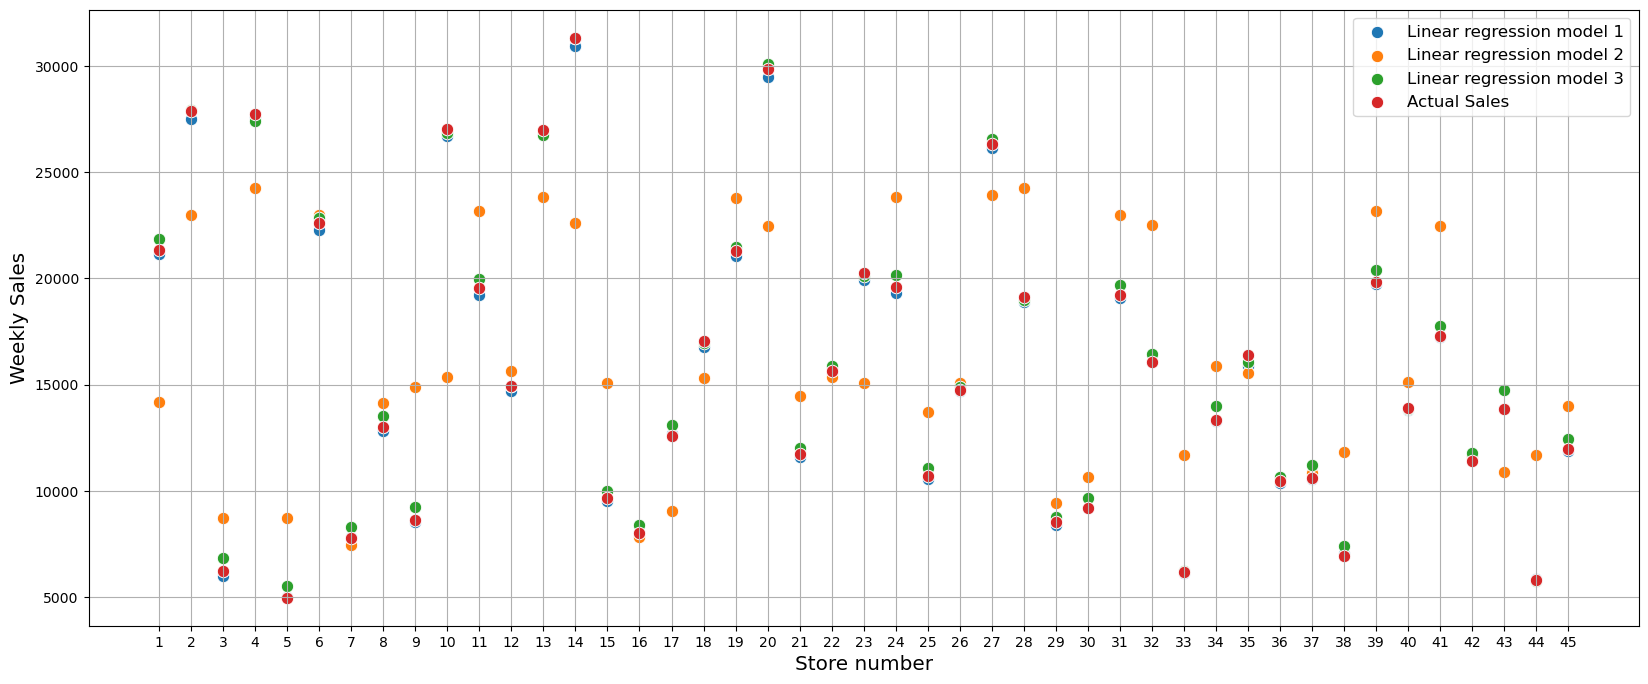

In [172]:
plt.figure(figsize=(20,8))
sns.scatterplot(x=vldt1_grouped.index, y=vldt1_grouped['y_vldt_pred'], label='Linear regression model 1',s=80)
sns.scatterplot(x=vldt2_grouped.index, y=vldt2_grouped['y_vldt_pred'], label='Linear regression model 2',s=80)
sns.scatterplot(x=vldt3_grouped.index, y=vldt3_grouped['y_vldt_pred'], label='Linear regression model 3',s=80)
sns.scatterplot(x=vldt3_grouped.index, y=vldt3_grouped['weeklySales'], label='Actual Sales',s=80)
plt.legend(fontsize='large') 
plt.xlabel('Store number',fontsize='x-large')
plt.ylabel('Weekly Sales',fontsize='x-large')
plt.xticks(np.arange(1, 46, step=1))
plt.grid()
plt

## Model 4: RNN GRU (autoregression)

In [153]:
# split to training dataset and validation dataset for RNN
raw_train = pd.get_dummies(raw, columns=['Store', 'Dept', 'Week', 'Type','Size_Group'])
raw_train['Store'] = raw['Store']
raw_train['Dept'] = raw['Dept']
raw_train['Week'] = raw['Week']
raw_train['Type'] = raw['Type']


raw_train_sorted = raw_train.sort_values(by=['Store', 'Dept', 'Date'], ascending=[True, True, False])
#print(raw_train_sorted)
#print(raw_train_sorted[0:10])

#train_w_na = raw_train_sorted[(raw_train_sorted['Year'] > 2010) & (raw_train_sorted['Date'] <= '2012-09-21')]
train = raw_train_sorted[raw_train_sorted['Year'] > 2010 ].dropna(subset=['weeklySales_5','weeklySales_4','weeklySales_3','weeklySales_2','weeklySales_1'])
#train = raw_train_sorted[raw_train_sorted['Year'] == 2011]

vldt = raw_train_sorted[raw_train_sorted['Year'] == 2010].dropna(subset=['weeklySales_5','weeklySales_4','weeklySales_3','weeklySales_2','weeklySales_1'])
print(vldt[0:10])


#print(train.head(5))

#pd.DataFrame(train.dtypes, columns=['Type'])

         Date  weeklySales  isHoliday  weeklySales_5  weeklySales_4  \
47 2010-12-31    -0.930916       True      -0.923635      -0.932816   
46 2010-12-24    -0.825466      False      -0.932816      -0.936024   
45 2010-12-17    -0.857033      False      -0.936024      -0.935972   
44 2010-12-10    -0.895467      False      -0.935972      -0.939913   
43 2010-12-03    -0.921195      False      -0.939913      -0.930916   
42 2010-11-26    -0.931787       True      -0.930916      -0.825466   
41 2010-11-19    -0.929689      False      -0.825466      -0.857033   
40 2010-11-12    -0.929698      False      -0.857033      -0.895467   
39 2010-11-05    -0.887614      False      -0.895467      -0.921195   
38 2010-10-29    -0.875002      False      -0.921195      -0.931787   

    weeklySales_3  weeklySales_2  weeklySales_1    Size  Size_norm  ...  \
47      -0.936024      -0.935972      -0.939913  151315   0.630267  ...   
46      -0.935972      -0.939913      -0.930916  151315   0.630267  

In [154]:
x_train = train.loc[:, 'weeklySales_5':'weeklySales_1']
y_train = train['weeklySales']

x_vldt = vldt.loc[:, 'weeklySales_5':'weeklySales_1']
y_vldt = vldt['weeklySales']

x_train = np.array(x_train)
x_vldt = np.array(x_vldt)
y_train = np.array(y_train)
y_vldt = np.array(y_vldt)

x_train = torch.tensor(x_train).unsqueeze(2).float()
x_vldt = torch.tensor(x_vldt).unsqueeze(2).float()
y_train = torch.tensor(y_train).unsqueeze(1).float()
y_vldt = torch.tensor(y_vldt).unsqueeze(1).float()

print('x_train.shape = ', x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_vldt.shape = ', x_vldt.shape)
print('y_vldt.shape = ', y_vldt.shape)
# Check for NaN values
nan_mask = torch.isnan(x_train)
#print("NaN values:", nan_mask)
print(sum(nan_mask))

# Check for infinite values
inf_mask = torch.isinf(x_train)
#print("Infinite values:", inf_mask)
print(sum(inf_mask))

x_train.shape =  torch.Size([264748, 5, 1])
y_train.shape =  torch.Size([264748, 1])
x_vldt.shape =  torch.Size([140461, 5, 1])
y_vldt.shape =  torch.Size([140461, 1])
tensor([[0],
        [0],
        [0],
        [0],
        [0]])
tensor([[0],
        [0],
        [0],
        [0],
        [0]])


In [131]:
print('x_train = ', x_train)
print('y_train = ', y_train)
print('x_vldt = ', x_vldt)
print('y_vldt = ', y_vldt)

x_train =  tensor([[[-0.9072],
         [-0.9164],
         [-0.9205],
         [-0.9230],
         [-0.9314]],

        [[-0.9164],
         [-0.9205],
         [-0.9230],
         [-0.9314],
         [-0.9306]],

        [[-0.9205],
         [-0.9230],
         [-0.9314],
         [-0.9306],
         [-0.9295]],

        ...,

        [[-0.9838],
         [-0.9849],
         [-0.9846],
         [-0.9855],
         [-0.9855]],

        [[-0.9849],
         [-0.9846],
         [-0.9855],
         [-0.9855],
         [-0.9857]],

        [[-0.9846],
         [-0.9855],
         [-0.9855],
         [-0.9857],
         [-0.9856]]])
y_train =  tensor([[-0.9306],
        [-0.9295],
        [-0.9332],
        ...,
        [-0.9857],
        [-0.9856],
        [-0.9854]])
x_vldt =  tensor([[[-0.9236],
         [-0.9328],
         [-0.9360],
         [-0.9360],
         [-0.9399]],

        [[-0.9328],
         [-0.9360],
         [-0.9360],
         [-0.9399],
         [-0.9309]],

        [[

In [132]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True).to(device)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :])
        return out
    

In [133]:
input_dim = 1
hidden_dim = 64
num_layers = 1
output_dim = 1
num_epochs = 500
learning_rate = 0.01
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


In [134]:
model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers).to(device)
#criterion = torch.nn.MSELoss(reduction='mean')
criterion = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [135]:
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []
for t in range(num_epochs):
    x_train = x_train.to(device)
    y_train = y_train.to(device)
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  1.1672883033752441
Epoch  1 MSE:  0.6857298016548157
Epoch  2 MSE:  0.3324624300003052
Epoch  3 MSE:  0.07648161053657532
Epoch  4 MSE:  0.019193310290575027
Epoch  5 MSE:  0.16912297904491425
Epoch  6 MSE:  0.08784851431846619
Epoch  7 MSE:  0.007425426039844751
Epoch  8 MSE:  0.014117209240794182
Epoch  9 MSE:  0.052118659019470215
Epoch  10 MSE:  0.07296251505613327
Epoch  11 MSE:  0.06670646369457245
Epoch  12 MSE:  0.04330063983798027
Epoch  13 MSE:  0.01777609996497631
Epoch  14 MSE:  0.003083928255364299
Epoch  15 MSE:  0.004867687355726957
Epoch  16 MSE:  0.017794549465179443
Epoch  17 MSE:  0.02877742424607277
Epoch  18 MSE:  0.028558041900396347
Epoch  19 MSE:  0.019028542563319206
Epoch  20 MSE:  0.008283589966595173
Epoch  21 MSE:  0.002446511760354042
Epoch  22 MSE:  0.002639003098011017
Epoch  23 MSE:  0.0065031289122998714
Epoch  24 MSE:  0.010793160647153854
Epoch  25 MSE:  0.01312591414898634
Epoch  26 MSE:  0.012628329917788506
Epoch  27 MSE:  0.0098249

Epoch  216 MSE:  0.0009383342694491148
Epoch  217 MSE:  0.0009318633819930255
Epoch  218 MSE:  0.0009253844036720693
Epoch  219 MSE:  0.0009188975091092288
Epoch  220 MSE:  0.0009124027565121651
Epoch  221 MSE:  0.0009059004951268435
Epoch  222 MSE:  0.0008993909577839077
Epoch  223 MSE:  0.0008928742026910186
Epoch  224 MSE:  0.0008863504626788199
Epoch  225 MSE:  0.0008798199705779552
Epoch  226 MSE:  0.0008732831920497119
Epoch  227 MSE:  0.0008667400106787682
Epoch  228 MSE:  0.0008601908921264112
Epoch  229 MSE:  0.0008536362438462675
Epoch  230 MSE:  0.000847076007630676
Epoch  231 MSE:  0.0008405109401792288
Epoch  232 MSE:  0.0008339409832842648
Epoch  233 MSE:  0.0008273665443994105
Epoch  234 MSE:  0.0008207879727706313
Epoch  235 MSE:  0.00081420544302091
Epoch  236 MSE:  0.0008076195954345167
Epoch  237 MSE:  0.0008010304882191122
Epoch  238 MSE:  0.0007944388198666275
Epoch  239 MSE:  0.0007878448814153671
Epoch  240 MSE:  0.0007812488474883139
Epoch  241 MSE:  0.000774651

Epoch  425 MSE:  0.00026733128470368683
Epoch  426 MSE:  0.0002673270064406097
Epoch  427 MSE:  0.000267322757281363
Epoch  428 MSE:  0.0002673185372259468
Epoch  429 MSE:  0.00026731425896286964
Epoch  430 MSE:  0.00026731009711511433
Epoch  431 MSE:  0.00026730590616352856
Epoch  432 MSE:  0.00026730174431577325
Epoch  433 MSE:  0.000267297524260357
Epoch  434 MSE:  0.00026729339151643217
Epoch  435 MSE:  0.0002672892005648464
Epoch  436 MSE:  0.0002672850387170911
Epoch  437 MSE:  0.00026728090597316623
Epoch  438 MSE:  0.0002672767441254109
Epoch  439 MSE:  0.0002672725822776556
Epoch  440 MSE:  0.0002672684204299003
Epoch  441 MSE:  0.00026726428768597543
Epoch  442 MSE:  0.00026726009673438966
Epoch  443 MSE:  0.00026725593488663435
Epoch  444 MSE:  0.0002672518021427095
Epoch  445 MSE:  0.00026724758208729327
Epoch  446 MSE:  0.0002672434493433684
Epoch  447 MSE:  0.0002672392874956131
Epoch  448 MSE:  0.00026723509654402733
Epoch  449 MSE:  0.000267230934696272
Epoch  450 MSE: 

In [136]:
predict = scaler.inverse_transform(y_train_pred.detach().cpu().numpy())
original = scaler.inverse_transform(y_train.detach().cpu().numpy())

train4 = train.copy()
train4['y_pred'] = predict
train4['weeklySales'] = original
print(np.mean(np.absolute(train4['weeklySales']-train4['y_pred'])*train4['Holiday_loss']))

2839.4199497589116


In [137]:
# make predictions
with torch.no_grad():
    x_vldt = x_vldt.to(device)
    y_vldt_pred = model(x_vldt)


predict_vldt = scaler.inverse_transform(y_vldt_pred.detach().cpu().numpy())
original_vldt = scaler.inverse_transform(y_vldt.detach().cpu().numpy())
vldt4 = vldt.copy()
vldt4['y_vldt_pred'] = predict_vldt
vldt4['weeklySales'] = original_vldt

print(np.mean(np.absolute(vldt4['weeklySales']-vldt4['y_vldt_pred'])*vldt4['Holiday_loss']))

3451.7659280157372


<module 'matplotlib.pyplot' from 'C:\\Users\\Yinkui\\anaconda3\\Lib\\site-packages\\matplotlib\\pyplot.py'>

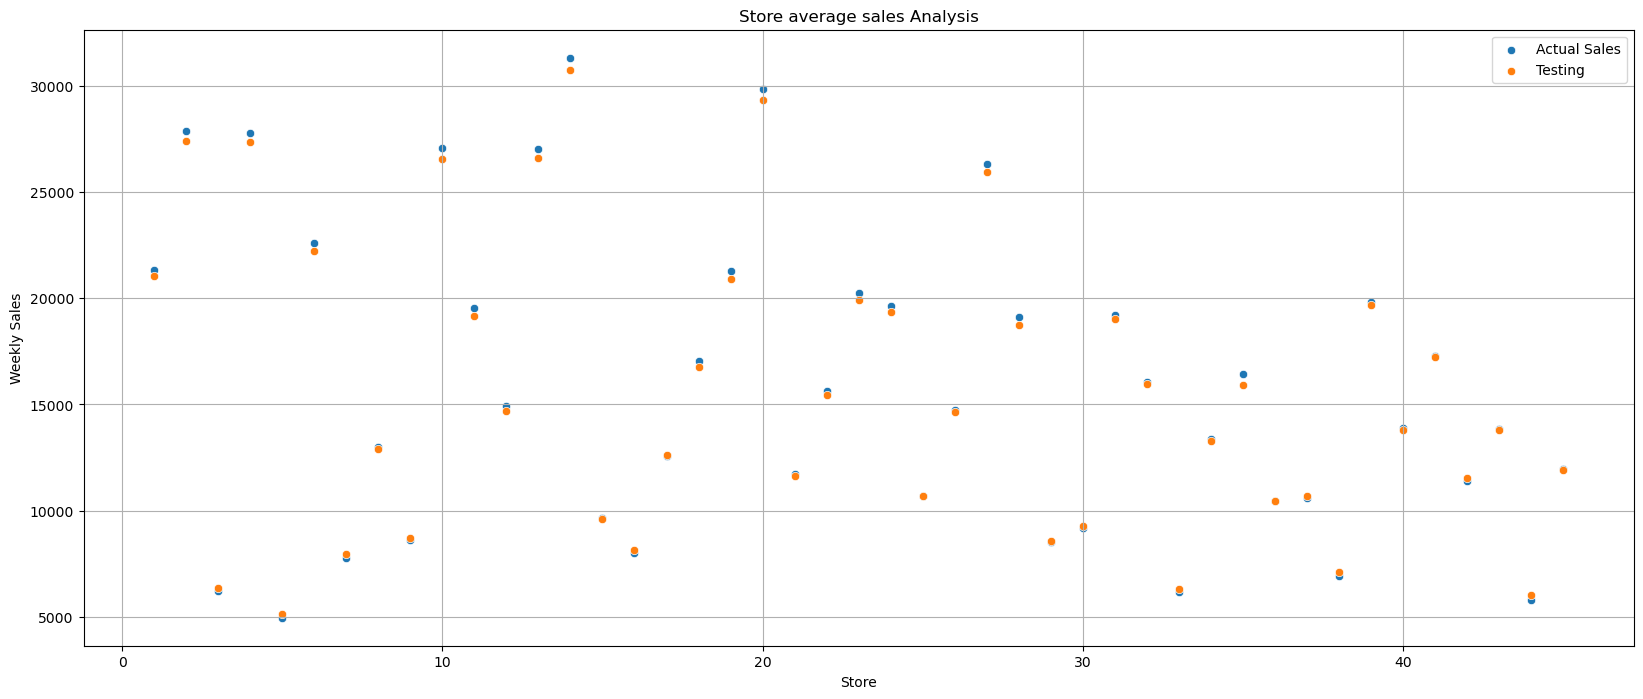

In [138]:
vldt4_grouped = vldt4.groupby(['Store'])[['weeklySales','y_vldt_pred']].mean()
train4_grouped = train4.groupby(['Store'])[['weeklySales','y_pred']].mean()
#print(vldt_grouped.head(5))

plt.figure(figsize=(20,8))

# Plot for Actual Sales in train_grouped
sns.scatterplot(x=vldt4_grouped.index, y=vldt4_grouped['weeklySales'], label='Actual Sales')

# Plot for Training (y_pred) in train_grouped
#sns.scatterplot(x=train4_grouped.index, y=train4_grouped['y_pred'], label='Training')

# Plot for Testing (y_vldt_pred) in vldt_grouped
sns.scatterplot(x=vldt4_grouped.index, y=vldt4_grouped['y_vldt_pred'], label='Testing')
#plt.xticks(np.arange(34875, 53, step=1))
plt.xlabel('Store')
plt.ylabel('Weekly Sales')
plt.title('Store average sales Analysis')
plt.grid()
plt

#Show average store sells prediction

<module 'matplotlib.pyplot' from 'C:\\Users\\Yinkui\\anaconda3\\Lib\\site-packages\\matplotlib\\pyplot.py'>

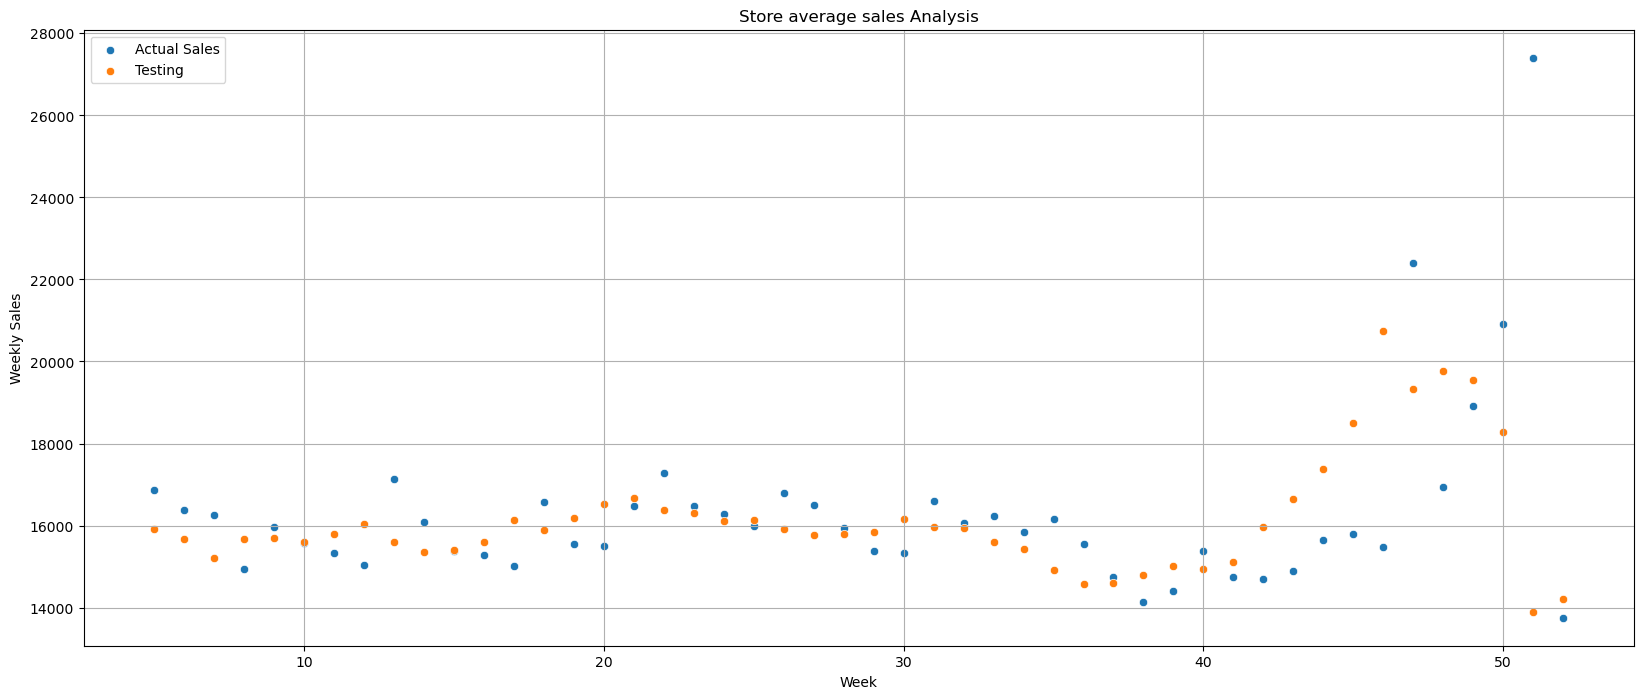

In [139]:
vldt4_grouped2 = vldt4.groupby(['Week'])[['weeklySales','y_vldt_pred']].mean()
train4_grouped2 = train4.groupby(['Week'])[['weeklySales','y_pred']].mean()
#print(vldt_grouped.head(5))

plt.figure(figsize=(20,8))

# Plot for Actual Sales in train_grouped
sns.scatterplot(x=vldt4_grouped2.index, y=vldt4_grouped2['weeklySales'], label='Actual Sales')

# Plot for Training (y_pred) in train_grouped
#sns.scatterplot(x=train4_grouped2.index, y=train4_grouped2['y_pred'], label='Training')

# Plot for Testing (y_vldt_pred) in vldt_grouped
sns.scatterplot(x=vldt4_grouped2.index, y=vldt4_grouped2['y_vldt_pred'], label='Testing')
#plt.xticks(np.arange(34875, 53, step=1))
plt.xlabel('Week')
plt.ylabel('Weekly Sales')
plt.title('Store average sales Analysis')
plt.grid()
plt

#Show average store sells prediction

## Model 5: GRU with lost customized loss function

In [140]:
# Convert Pandas Series to NumPy array
holiday_loss_array = train['Holiday_loss'].to_numpy()

# Convert NumPy array to PyTorch tensor
holiday_loss_tensor = torch.tensor(holiday_loss_array).unsqueeze(1).float().to(device)

print(holiday_loss_tensor)


tensor([[1.],
        [1.],
        [5.],
        ...,
        [1.],
        [1.],
        [1.]], device='cuda:0')


In [141]:
def custom_loss(output, target, holiday_loss_tensor):
    return torch.mean(torch.abs(output - target) * holiday_loss_tensor)


In [142]:
model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers).to(device)

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [143]:
input_dim = 1
hidden_dim = 64
num_layers = 1
output_dim = 1
num_epochs = 500
learning_rate = 0.01
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [144]:
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []
for t in range(num_epochs):
    x_train = x_train.to(device)
    y_train = y_train.to(device)
    y_train_pred = model(x_train)
    loss = custom_loss(y_train_pred, y_train, holiday_loss_tensor)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  1.1716002225875854
Epoch  1 MSE:  0.8713439106941223
Epoch  2 MSE:  0.5097235441207886
Epoch  3 MSE:  0.03238368406891823
Epoch  4 MSE:  0.833710253238678
Epoch  5 MSE:  0.5975767374038696
Epoch  6 MSE:  0.15109719336032867
Epoch  7 MSE:  0.2637553811073303
Epoch  8 MSE:  0.4280027747154236
Epoch  9 MSE:  0.47881245613098145
Epoch  10 MSE:  0.4656204283237457
Epoch  11 MSE:  0.4092695116996765
Epoch  12 MSE:  0.3181245028972626
Epoch  13 MSE:  0.19464817643165588
Epoch  14 MSE:  0.052816011011600494
Epoch  15 MSE:  0.16616962850093842
Epoch  16 MSE:  0.2657935917377472
Epoch  17 MSE:  0.27424195408821106
Epoch  18 MSE:  0.21148158609867096
Epoch  19 MSE:  0.10213823616504669
Epoch  20 MSE:  0.056302499026060104
Epoch  21 MSE:  0.12408609688282013
Epoch  22 MSE:  0.1597442775964737
Epoch  23 MSE:  0.16208957135677338
Epoch  24 MSE:  0.13600291311740875
Epoch  25 MSE:  0.08777671307325363
Epoch  26 MSE:  0.036871686577796936
Epoch  27 MSE:  0.09028107672929764
Epoch  28 MS

Epoch  223 MSE:  0.024014750495553017
Epoch  224 MSE:  0.02065354958176613
Epoch  225 MSE:  0.023759938776493073
Epoch  226 MSE:  0.014802047051489353
Epoch  227 MSE:  0.017246650531888008
Epoch  228 MSE:  0.01456340029835701
Epoch  229 MSE:  0.015318362042307854
Epoch  230 MSE:  0.020832447335124016
Epoch  231 MSE:  0.01661757566034794
Epoch  232 MSE:  0.026975495740771294
Epoch  233 MSE:  0.013563700951635838
Epoch  234 MSE:  0.017751073464751244
Epoch  235 MSE:  0.013242662884294987
Epoch  236 MSE:  0.014842338860034943
Epoch  237 MSE:  0.031127411872148514
Epoch  238 MSE:  0.027793671935796738
Epoch  239 MSE:  0.021292783319950104
Epoch  240 MSE:  0.013018818572163582
Epoch  241 MSE:  0.03400522097945213
Epoch  242 MSE:  0.02984457276761532
Epoch  243 MSE:  0.02120007760822773
Epoch  244 MSE:  0.014820080250501633
Epoch  245 MSE:  0.0400068536400795
Epoch  246 MSE:  0.04135063290596008
Epoch  247 MSE:  0.011740022338926792
Epoch  248 MSE:  0.05285080149769783
Epoch  249 MSE:  0.047

Epoch  442 MSE:  0.02866186387836933
Epoch  443 MSE:  0.013416685163974762
Epoch  444 MSE:  0.020938729867339134
Epoch  445 MSE:  0.011894590221345425
Epoch  446 MSE:  0.026704443618655205
Epoch  447 MSE:  0.020637070760130882
Epoch  448 MSE:  0.021573876962065697
Epoch  449 MSE:  0.027394529432058334
Epoch  450 MSE:  0.012280796654522419
Epoch  451 MSE:  0.033212579786777496
Epoch  452 MSE:  0.03379053995013237
Epoch  453 MSE:  0.009941285476088524
Epoch  454 MSE:  0.022156719118356705
Epoch  455 MSE:  0.015780853107571602
Epoch  456 MSE:  0.022110719233751297
Epoch  457 MSE:  0.018838461488485336
Epoch  458 MSE:  0.02061798982322216
Epoch  459 MSE:  0.023820042610168457
Epoch  460 MSE:  0.00921409297734499
Epoch  461 MSE:  0.028156738728284836
Epoch  462 MSE:  0.018382957205176353
Epoch  463 MSE:  0.026062171906232834
Epoch  464 MSE:  0.032502513378858566
Epoch  465 MSE:  0.013988289050757885
Epoch  466 MSE:  0.03578060865402222
Epoch  467 MSE:  0.0419011190533638
Epoch  468 MSE:  0.

In [145]:
predict = scaler.inverse_transform(y_train_pred.detach().cpu().numpy())
original = scaler.inverse_transform(y_train.detach().cpu().numpy())

train5 = train.copy()
train5['y_pred'] = predict
train5['weeklySales'] = original
print(np.mean(np.absolute(train5['weeklySales']-train5['y_pred'])*train5['Holiday_loss']))

12675.675977130068


In [146]:
# make predictions
with torch.no_grad():
    x_vldt = x_vldt.to(device)
    y_vldt_pred = model(x_vldt)


predict_vldt = scaler.inverse_transform(y_vldt_pred.detach().cpu().numpy())
original_vldt = scaler.inverse_transform(y_vldt.detach().cpu().numpy())
vldt5 = vldt.copy()
vldt5['y_vldt_pred'] = predict_vldt
vldt5['weeklySales'] = original_vldt

print(np.mean(np.absolute(vldt5['weeklySales']-vldt5['y_vldt_pred'])*vldt5['Holiday_loss']))

3808.923047927713


<module 'matplotlib.pyplot' from 'C:\\Users\\Yinkui\\anaconda3\\Lib\\site-packages\\matplotlib\\pyplot.py'>

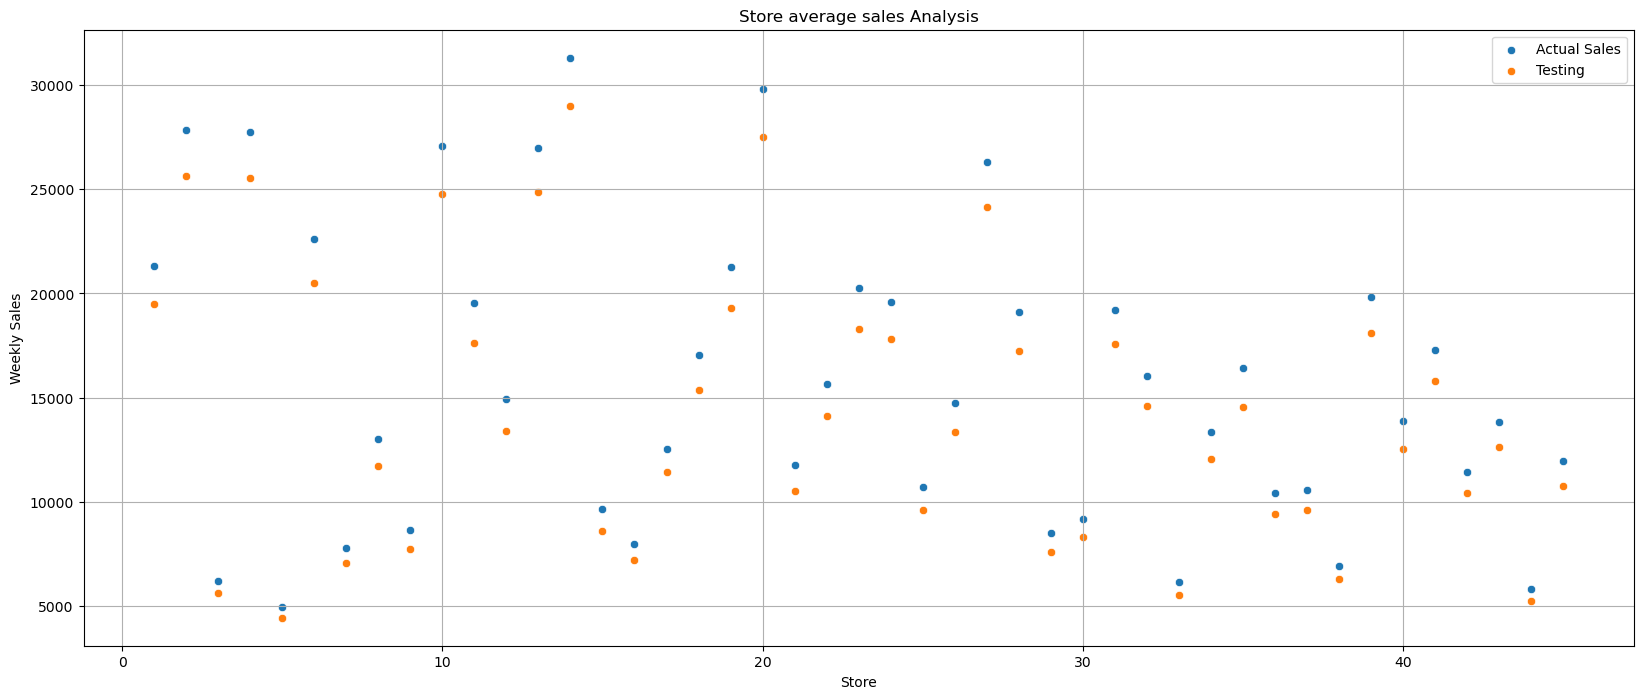

In [147]:
vldt5_grouped = vldt5.groupby(['Store'])[['weeklySales','y_vldt_pred']].mean()
train5_grouped = train5.groupby(['Store'])[['weeklySales','y_pred']].mean()
#print(vldt_grouped.head(5))

plt.figure(figsize=(20,8))

# Plot for Actual Sales in train_grouped
sns.scatterplot(x=vldt5_grouped.index, y=vldt5_grouped['weeklySales'], label='Actual Sales')

# Plot for Actual Sales in train_grouped
#sns.scatterplot(x=train5_grouped.index, y=train5_grouped['weeklySales'], label='Actual Sales')

# Plot for Training (y_pred) in train_grouped
#sns.scatterplot(x=train4_grouped.index, y=train4_grouped['y_pred'], label='Training')

# Plot for Testing (y_vldt_pred) in vldt_grouped
sns.scatterplot(x=vldt5_grouped.index, y=vldt5_grouped['y_vldt_pred'], label='Testing')
#plt.xticks(np.arange(34875, 53, step=1))
plt.xlabel('Store')
plt.ylabel('Weekly Sales')
plt.title('Store average sales Analysis')
plt.grid()
plt

#Show average store sells prediction

<module 'matplotlib.pyplot' from 'C:\\Users\\Yinkui\\anaconda3\\Lib\\site-packages\\matplotlib\\pyplot.py'>

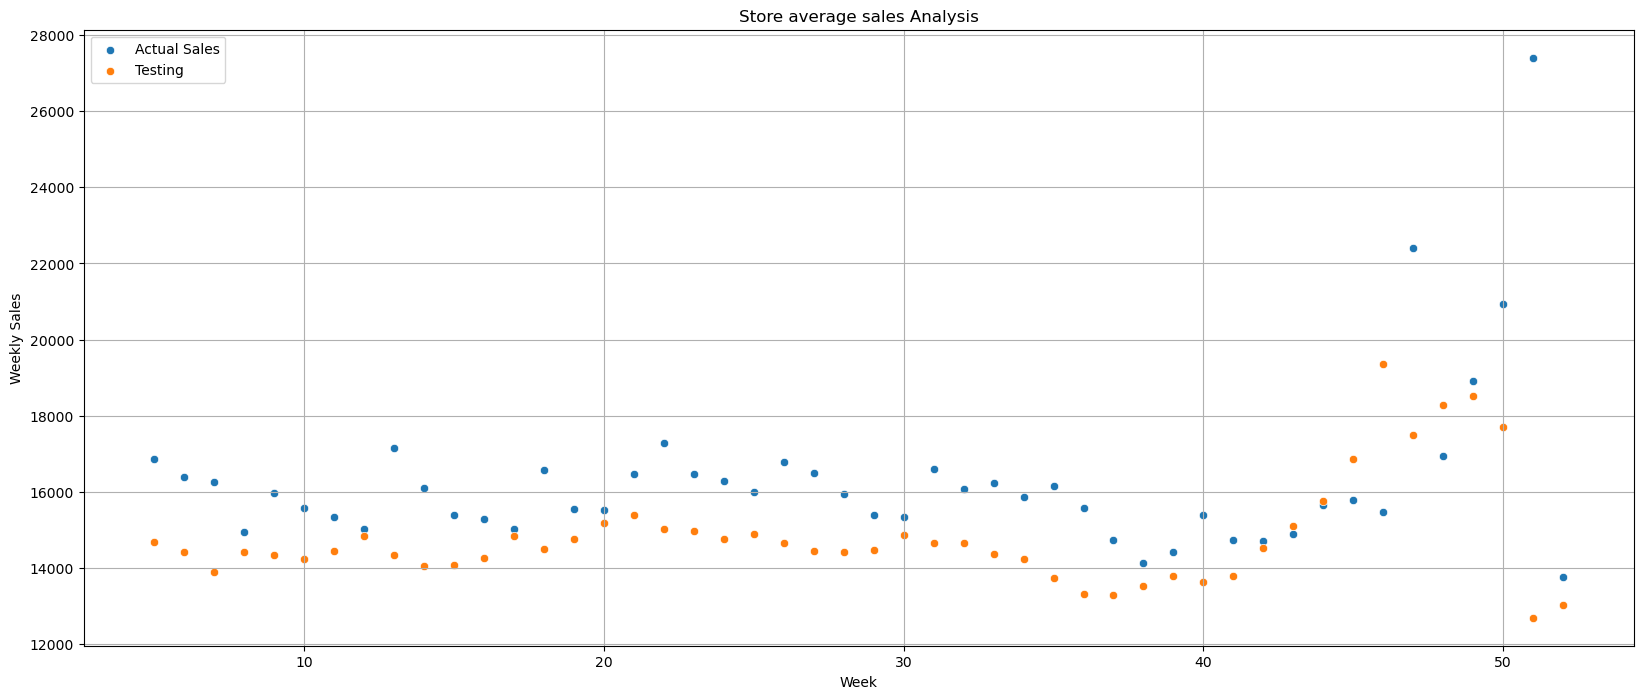

In [148]:
vldt5_grouped2 = vldt5.groupby(['Week'])[['weeklySales','y_vldt_pred']].mean()
train5_grouped2 = train5.groupby(['Week'])[['weeklySales','y_pred']].mean()
#print(vldt_grouped.head(5))

plt.figure(figsize=(20,8))

# Plot for Actual Sales in train_grouped
sns.scatterplot(x=vldt5_grouped2.index, y=vldt5_grouped2['weeklySales'], label='Actual Sales')

# Plot for Training (y_pred) in train_grouped
#sns.scatterplot(x=train4_grouped2.index, y=train4_grouped2['y_pred'], label='Training')

# Plot for Testing (y_vldt_pred) in vldt_grouped
sns.scatterplot(x=vldt5_grouped2.index, y=vldt5_grouped2['y_vldt_pred'], label='Testing')
#plt.xticks(np.arange(34875, 53, step=1))
plt.xlabel('Week')
plt.ylabel('Weekly Sales')
plt.title('Store average sales Analysis')
plt.grid()
plt

#Show average store sells prediction

## Model 6: GRU with all the features

In [ ]:
# Data Management
columns = list(train.columns)
print(columns)


In [149]:

df1 = train.loc[:, 'Store_1':'Type_C']
df2 = train.loc[:, 'Size_norm':'Size_norm']
df3 = train.loc[:, 'Temperature_norm':'Unemployment_norm']
df4 = train.loc[:, 'MarkDown1_Ind':'Holiday_Ind']
df5 = train.loc[:,'weeklySales_5':'weeklySales_1']
x_train = np.concatenate((df1, df2, df3, df4, df5), axis=1)
y_train = train['weeklySales']


df1 = vldt.loc[:, 'Store_1':'Type_C']
df2 = vldt.loc[:, 'Size_norm':'Size_norm']
df3 = vldt.loc[:, 'Temperature_norm':'Unemployment_norm']
df4 = vldt.loc[:, 'MarkDown1_Ind':'Holiday_Ind']
df5 = vldt.loc[:,'weeklySales_5':'weeklySales_1']
x_vldt = np.concatenate((df1, df2, df3, df4, df5), axis=1)
y_vldt = vldt['weeklySales']


y_train = np.array(y_train)
y_vldt = np.array(y_vldt)

x_train = torch.tensor(x_train).unsqueeze(2).float()
x_vldt = torch.tensor(x_vldt).unsqueeze(2).float()
y_train = torch.tensor(y_train).unsqueeze(1).float()
y_vldt = torch.tensor(y_vldt).unsqueeze(1).float()

print('x_train.shape = ', x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_vldt.shape = ', x_vldt.shape)
print('y_vldt.shape = ', y_vldt.shape)
# Check for NaN values
nan_mask = torch.isnan(x_train)
#print("NaN values:", nan_mask)
print(sum(nan_mask))

# Check for infinite values
inf_mask = torch.isinf(x_train)
#print("Infinite values:", inf_mask)
print(sum(inf_mask))

x_train.shape =  torch.Size([264748, 197, 1])
y_train.shape =  torch.Size([264748, 1])
x_vldt.shape =  torch.Size([140461, 197, 1])
y_vldt.shape =  torch.Size([140461, 1])
tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [

## LSTM autoregression

In [150]:
class LSTMNetbuildin(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, bias=True):
        super(LSTMNetbuildin, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        # Built-in LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_dim)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

In [151]:

model = LSTMNetbuildin(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers).to(device)
criterion = nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [155]:
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []
for t in range(num_epochs):
    x_train = x_train.to(device)
    y_train = y_train.to(device)
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  1.004898190498352
Epoch  1 MSE:  0.6699272990226746
Epoch  2 MSE:  0.3442191183567047
Epoch  3 MSE:  0.05350295454263687
Epoch  4 MSE:  0.1383543163537979
Epoch  5 MSE:  0.13933677971363068
Epoch  6 MSE:  0.01709901914000511
Epoch  7 MSE:  0.013139119371771812
Epoch  8 MSE:  0.05960262939333916
Epoch  9 MSE:  0.08200106024742126
Epoch  10 MSE:  0.06951530277729034
Epoch  11 MSE:  0.03777296096086502
Epoch  12 MSE:  0.009234144352376461
Epoch  13 MSE:  0.002860402222722769
Epoch  14 MSE:  0.019395645707845688
Epoch  15 MSE:  0.03602389246225357
Epoch  16 MSE:  0.033023469150066376
Epoch  17 MSE:  0.016848772764205933
Epoch  18 MSE:  0.004326649010181427
Epoch  19 MSE:  0.00266843568533659
Epoch  20 MSE:  0.008420431986451149
Epoch  21 MSE:  0.015053940005600452
Epoch  22 MSE:  0.018097421154379845
Epoch  23 MSE:  0.016348056495189667
Epoch  24 MSE:  0.01123600173741579
Epoch  25 MSE:  0.0056429579854011536
Epoch  26 MSE:  0.002458350034430623
Epoch  27 MSE:  0.00302093848

Epoch  216 MSE:  0.0010148754809051752
Epoch  217 MSE:  0.001004199031740427
Epoch  218 MSE:  0.0009935316629707813
Epoch  219 MSE:  0.0009828745387494564
Epoch  220 MSE:  0.0009722296963445842
Epoch  221 MSE:  0.0009615986491553485
Epoch  222 MSE:  0.0009509832016192377
Epoch  223 MSE:  0.0009403850417584181
Epoch  224 MSE:  0.0009298059158027172
Epoch  225 MSE:  0.0009192474535666406
Epoch  226 MSE:  0.0009087113430723548
Epoch  227 MSE:  0.0008981995633803308
Epoch  228 MSE:  0.000887713860720396
Epoch  229 MSE:  0.0008772564469836652
Epoch  230 MSE:  0.0008668289519846439
Epoch  231 MSE:  0.0008564337040297687
Epoch  232 MSE:  0.0008460722747258842
Epoch  233 MSE:  0.0008357467595487833
Epoch  234 MSE:  0.0008254593703895807
Epoch  235 MSE:  0.0008152120281010866
Epoch  236 MSE:  0.0008050071191973984
Epoch  237 MSE:  0.000794846739154309
Epoch  238 MSE:  0.0007847329252399504
Epoch  239 MSE:  0.0007746678893454373
Epoch  240 MSE:  0.0007646537851542234
Epoch  241 MSE:  0.000754692

Epoch  425 MSE:  0.00027855602093040943
Epoch  426 MSE:  0.000278553634416312
Epoch  427 MSE:  0.000278551277006045
Epoch  428 MSE:  0.00027854889049194753
Epoch  429 MSE:  0.0002785465039778501
Epoch  430 MSE:  0.0002785441465675831
Epoch  431 MSE:  0.00027854176005348563
Epoch  432 MSE:  0.0002785393735393882
Epoch  433 MSE:  0.00027853698702529073
Epoch  434 MSE:  0.0002785346005111933
Epoch  435 MSE:  0.0002785322139970958
Epoch  436 MSE:  0.00027852982748299837
Epoch  437 MSE:  0.00027852741186507046
Epoch  438 MSE:  0.000278525025350973
Epoch  439 MSE:  0.00027852263883687556
Epoch  440 MSE:  0.0002785202523227781
Epoch  441 MSE:  0.00027851786580868065
Epoch  442 MSE:  0.0002785154210869223
Epoch  443 MSE:  0.00027851303457282484
Epoch  444 MSE:  0.0002785106480587274
Epoch  445 MSE:  0.0002785082324407995
Epoch  446 MSE:  0.000278505845926702
Epoch  447 MSE:  0.00027850340120494366
Epoch  448 MSE:  0.0002785009564831853
Epoch  449 MSE:  0.00027849856996908784
Epoch  450 MSE:  0

In [156]:
predict = scaler.inverse_transform(y_train_pred.detach().cpu().numpy())
original = scaler.inverse_transform(y_train.detach().cpu().numpy())

train6 = train.copy()
train6['y_pred'] = predict
train6['weeklySales'] = original
print(np.mean(np.absolute(train6['weeklySales']-train6['y_pred'])*train6['Holiday_loss']))

2854.9851062682533


In [157]:
# make predictions
with torch.no_grad():
    x_vldt = x_vldt.to(device)
    y_vldt_pred = model(x_vldt)


predict_vldt = scaler.inverse_transform(y_vldt_pred.detach().cpu().numpy())
original_vldt = scaler.inverse_transform(y_vldt.detach().cpu().numpy())
vldt6 = vldt.copy()
vldt6['y_vldt_pred'] = predict_vldt
vldt6['weeklySales'] = original_vldt

print(np.mean(np.absolute(vldt6['weeklySales']-vldt6['y_vldt_pred'])*vldt6['Holiday_loss']))

3479.3597750891768


<module 'matplotlib.pyplot' from 'C:\\Users\\Yinkui\\anaconda3\\Lib\\site-packages\\matplotlib\\pyplot.py'>

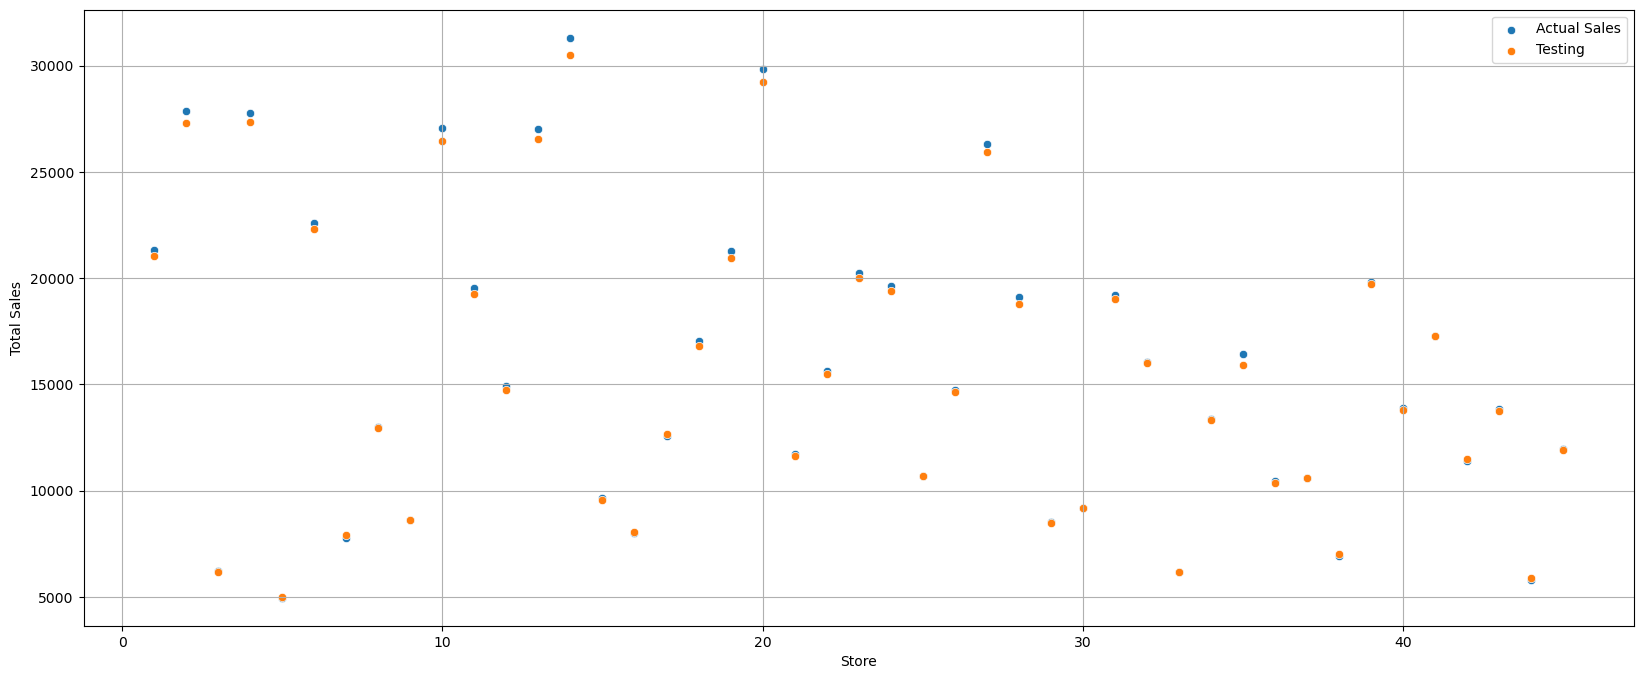

In [159]:
vldt6_grouped = vldt6.groupby(['Store'])[['weeklySales','y_vldt_pred']].mean()
train6_grouped = train6.groupby(['Store'])[['weeklySales','y_pred']].mean()
#print(vldt_grouped.head(5))

plt.figure(figsize=(20,8))

# Plot for Actual Sales in train_grouped
sns.scatterplot(x=vldt6_grouped.index, y=vldt6_grouped['weeklySales'], label='Actual Sales')

# Plot for Training (y_pred) in train_grouped
#sns.scatterplot(x=train4_grouped2.index, y=train4_grouped2['y_pred'], label='Training')

# Plot for Testing (y_vldt_pred) in vldt_grouped
sns.scatterplot(x=vldt6_grouped.index, y=vldt6_grouped['y_vldt_pred'], label='Testing')
#plt.xticks(np.arange(34875, 53, step=1))
plt.xlabel('Store')
plt.ylabel('Total Sales')

plt.grid()
plt

#Show average store sells prediction

<module 'matplotlib.pyplot' from 'C:\\Users\\Yinkui\\anaconda3\\Lib\\site-packages\\matplotlib\\pyplot.py'>

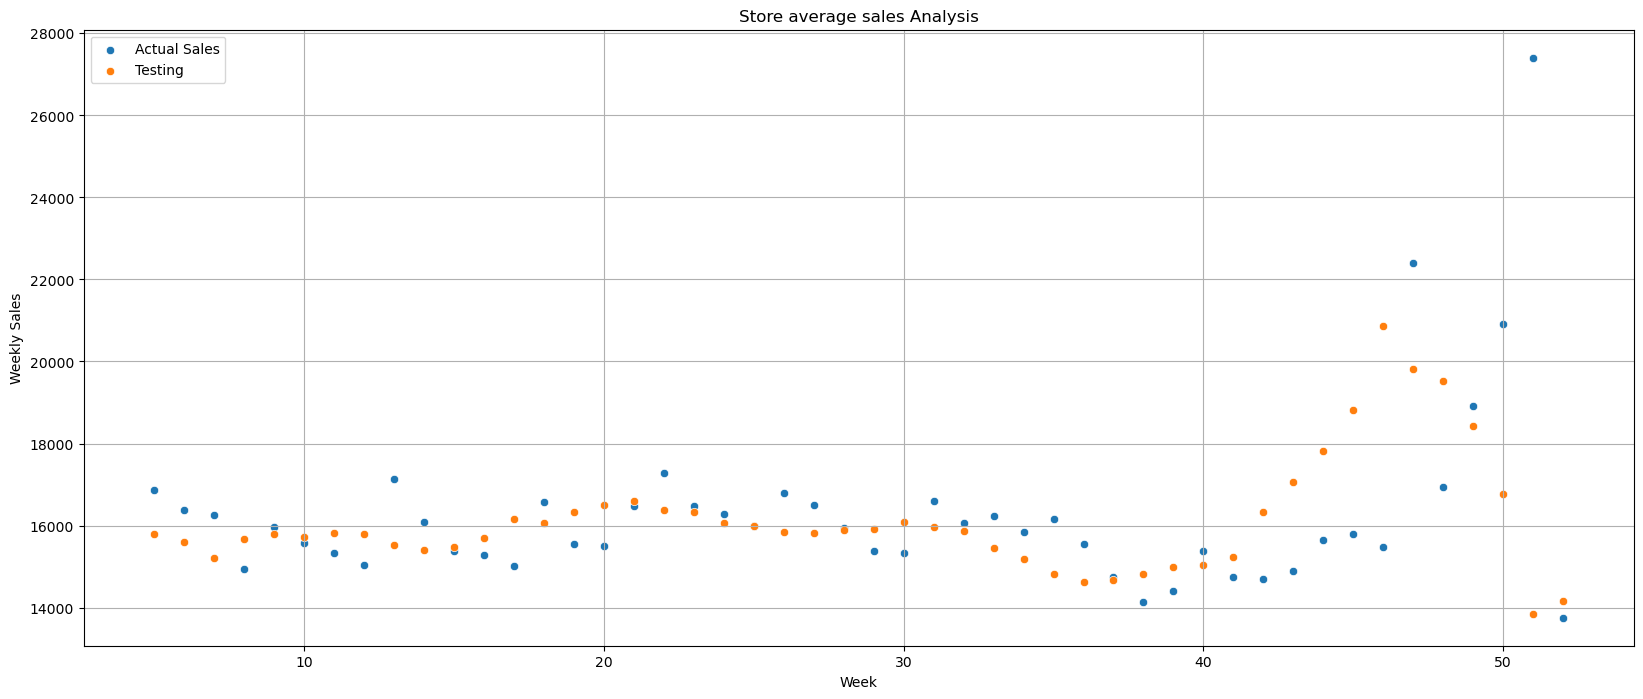

In [158]:
vldt6_grouped2 = vldt6.groupby(['Week'])[['weeklySales','y_vldt_pred']].mean()
train6_grouped2 = train6.groupby(['Week'])[['weeklySales','y_pred']].mean()
#print(vldt_grouped.head(5))

plt.figure(figsize=(20,8))

# Plot for Actual Sales in train_grouped
sns.scatterplot(x=vldt6_grouped2.index, y=vldt6_grouped2['weeklySales'], label='Actual Sales')

# Plot for Training (y_pred) in train_grouped
#sns.scatterplot(x=train4_grouped2.index, y=train4_grouped2['y_pred'], label='Training')

# Plot for Testing (y_vldt_pred) in vldt_grouped
sns.scatterplot(x=vldt6_grouped2.index, y=vldt6_grouped2['y_vldt_pred'], label='Testing')
#plt.xticks(np.arange(34875, 53, step=1))
plt.xlabel('Week')
plt.ylabel('Weekly Sales')
plt.title('Store average sales Analysis')
plt.grid()
plt

#Show average store sells prediction

## RNN model plots

In [164]:
# Convert index to datetime if it's in a recognizable date format
vldt4_grouped2.index = pd.to_datetime(vldt4_grouped2.index, errors='coerce')
vldt5_grouped2.index = pd.to_datetime(vldt5_grouped2.index, errors='coerce')
vldt6_grouped2.index = pd.to_datetime(vldt6_grouped2.index, errors='coerce')

# Check if there are any NaT (Not a Time) values which indicate conversion errors
print(vldt1_grouped2.index.isnull().sum())
print(vldt2_grouped2.index.isnull().sum())
print(vldt3_grouped2.index.isnull().sum())

# If the index is not a date, ensure it's numeric
vldt4_grouped2.index = pd.to_numeric(vldt4_grouped2.index, errors='coerce')
vldt5_grouped2.index = pd.to_numeric(vldt5_grouped2.index, errors='coerce')
vldt6_grouped2.index = pd.to_numeric(vldt6_grouped2.index, errors='coerce')

# Check again for NaN values after conversion
print(vldt1_grouped2.index.isnull().sum())
print(vldt2_grouped2.index.isnull().sum())
print(vldt3_grouped2.index.isnull().sum())

0
0
0
0
0
0


<module 'matplotlib.pyplot' from 'C:\\Users\\Yinkui\\anaconda3\\Lib\\site-packages\\matplotlib\\pyplot.py'>

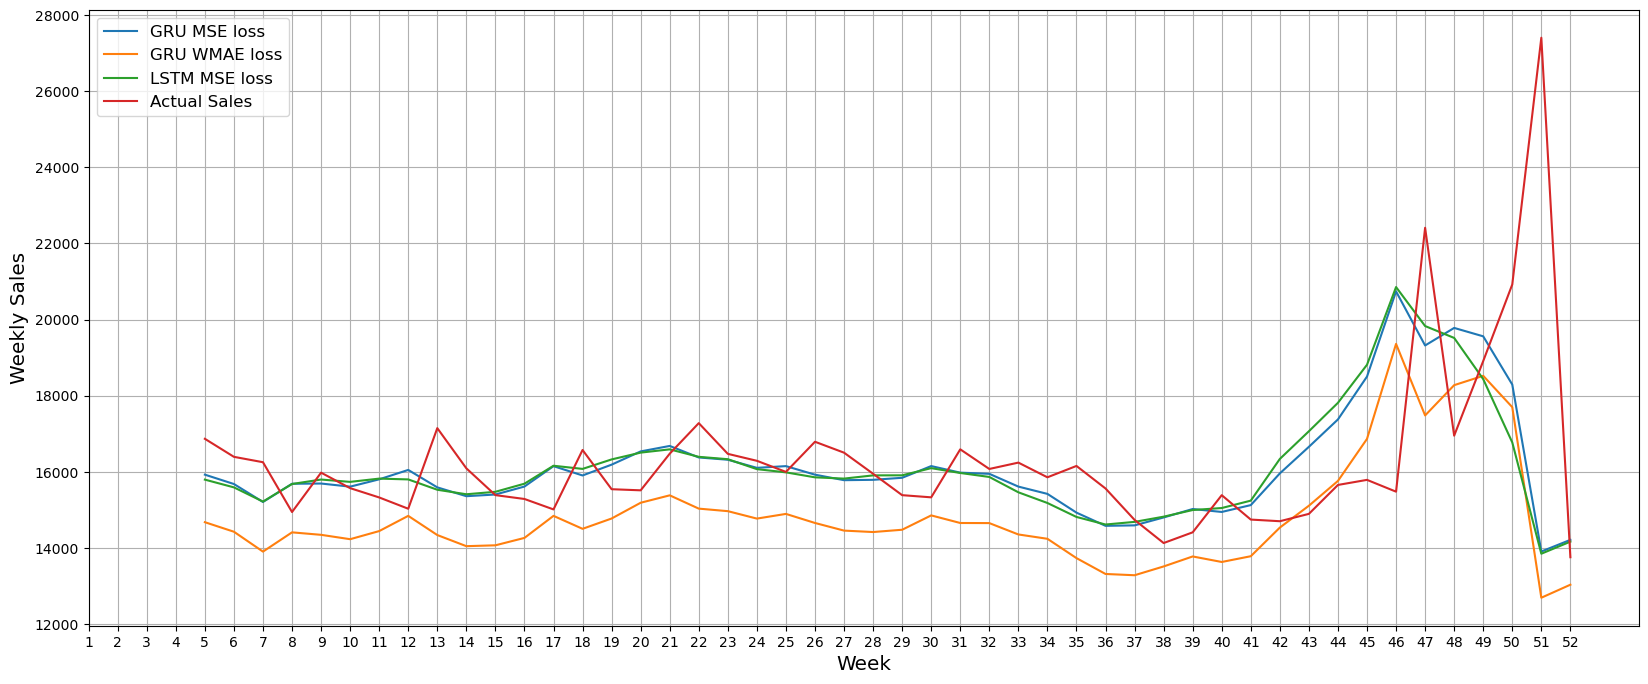

In [165]:
plt.figure(figsize=(20,8))
sns.lineplot(x=vldt4_grouped2.index, y=vldt4_grouped2['y_vldt_pred'], label='GRU MSE loss')
sns.lineplot(x=vldt5_grouped2.index, y=vldt5_grouped2['y_vldt_pred'], label='GRU WMAE loss')
sns.lineplot(x=vldt6_grouped2.index, y=vldt6_grouped2['y_vldt_pred'], label='LSTM MSE loss')
sns.lineplot(x=vldt3_grouped2.index, y=vldt3_grouped2['weeklySales'], label='Actual Sales')
plt.legend(fontsize='large') 
plt.xlabel('Week',fontsize='x-large')
plt.ylabel('Weekly Sales',fontsize='x-large')
plt.xticks(np.arange(1, 53, step=1))
plt.grid()
plt

<module 'matplotlib.pyplot' from 'C:\\Users\\Yinkui\\anaconda3\\Lib\\site-packages\\matplotlib\\pyplot.py'>

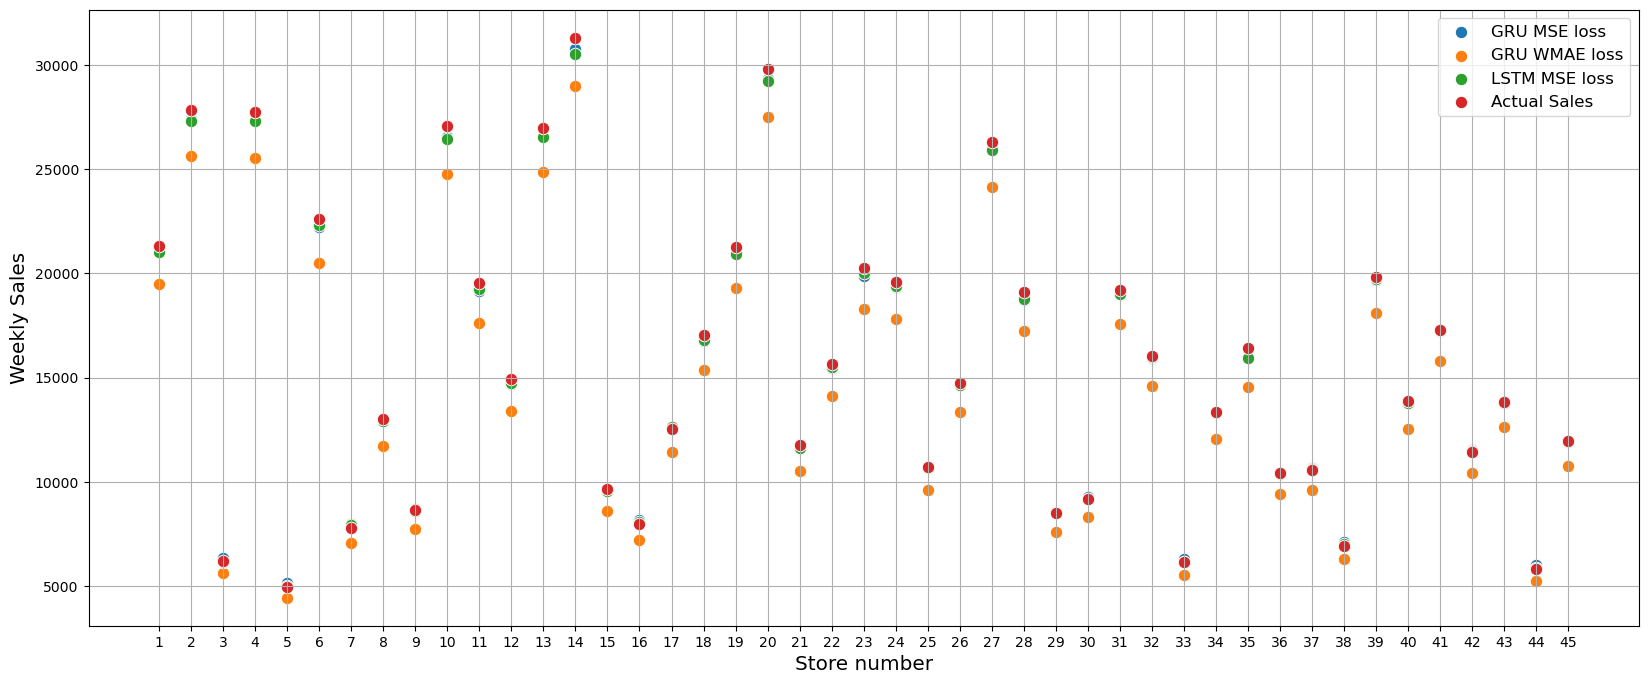

In [170]:
plt.figure(figsize=(20,8))
sns.scatterplot(x=vldt4_grouped.index, y=vldt4_grouped['y_vldt_pred'], label='GRU MSE loss',s=80)
sns.scatterplot(x=vldt5_grouped.index, y=vldt5_grouped['y_vldt_pred'], label='GRU WMAE loss',s=80)
sns.scatterplot(x=vldt6_grouped.index, y=vldt6_grouped['y_vldt_pred'], label='LSTM MSE loss',s=80)
sns.scatterplot(x=vldt3_grouped.index, y=vldt3_grouped['weeklySales'], label='Actual Sales',s=80)
plt.legend(fontsize='large') 
plt.xlabel('Store number',fontsize='x-large')
plt.ylabel('Weekly Sales',fontsize='x-large')
plt.xticks(np.arange(1, 46, step=1))
plt.grid()
plt

<module 'matplotlib.pyplot' from 'C:\\Users\\Yinkui\\anaconda3\\Lib\\site-packages\\matplotlib\\pyplot.py'>

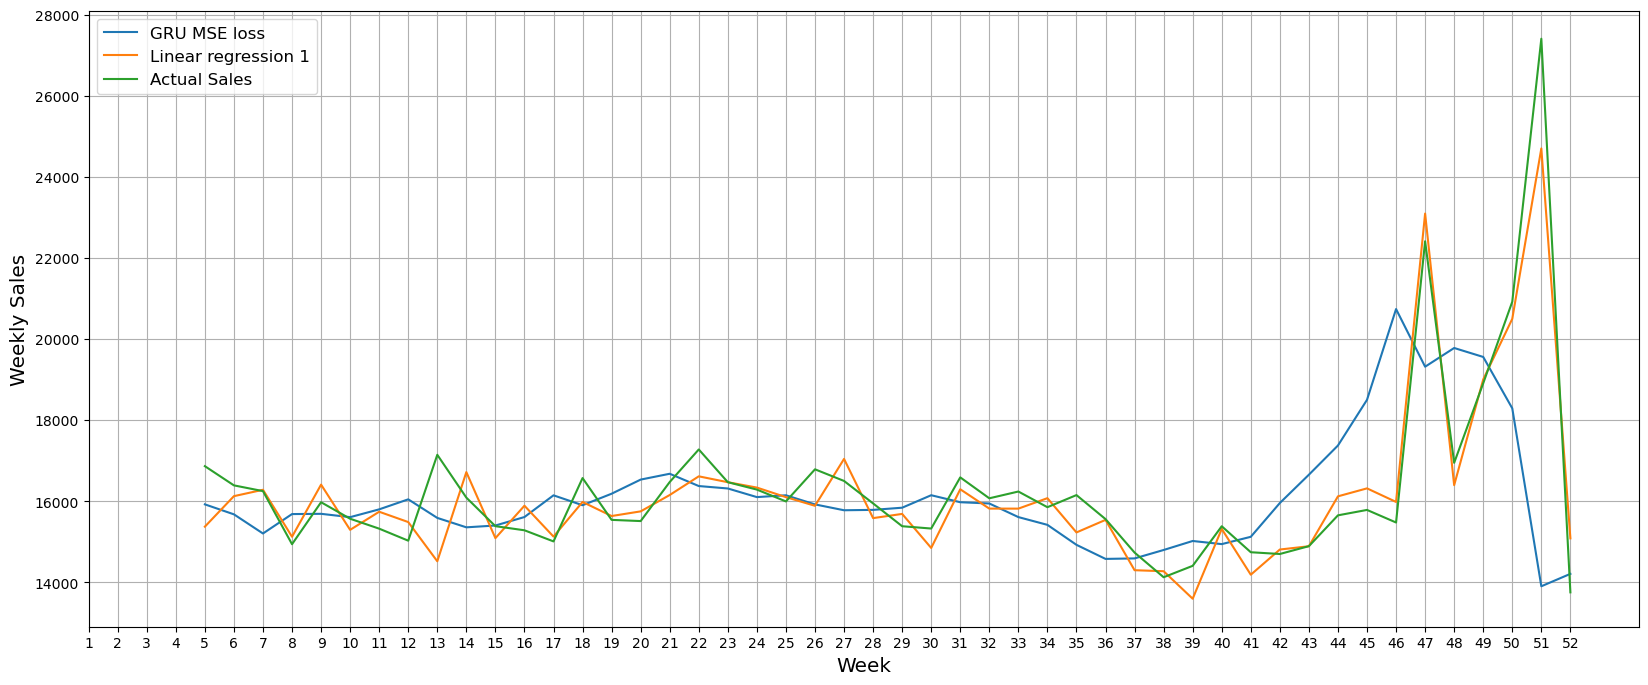

In [173]:
plt.figure(figsize=(20,8))
sns.lineplot(x=vldt4_grouped2.index, y=vldt4_grouped2['y_vldt_pred'], label='GRU MSE loss')

sns.lineplot(x=vldt1_grouped2.index, y=vldt1_grouped2['y_vldt_pred'], label='Linear regression 1')
sns.lineplot(x=vldt3_grouped2.index, y=vldt3_grouped2['weeklySales'], label='Actual Sales')
plt.legend(fontsize='large') 
plt.xlabel('Week',fontsize='x-large')
plt.ylabel('Weekly Sales',fontsize='x-large')
plt.xticks(np.arange(1, 53, step=1))
plt.grid()
plt

<module 'matplotlib.pyplot' from 'C:\\Users\\Yinkui\\anaconda3\\Lib\\site-packages\\matplotlib\\pyplot.py'>

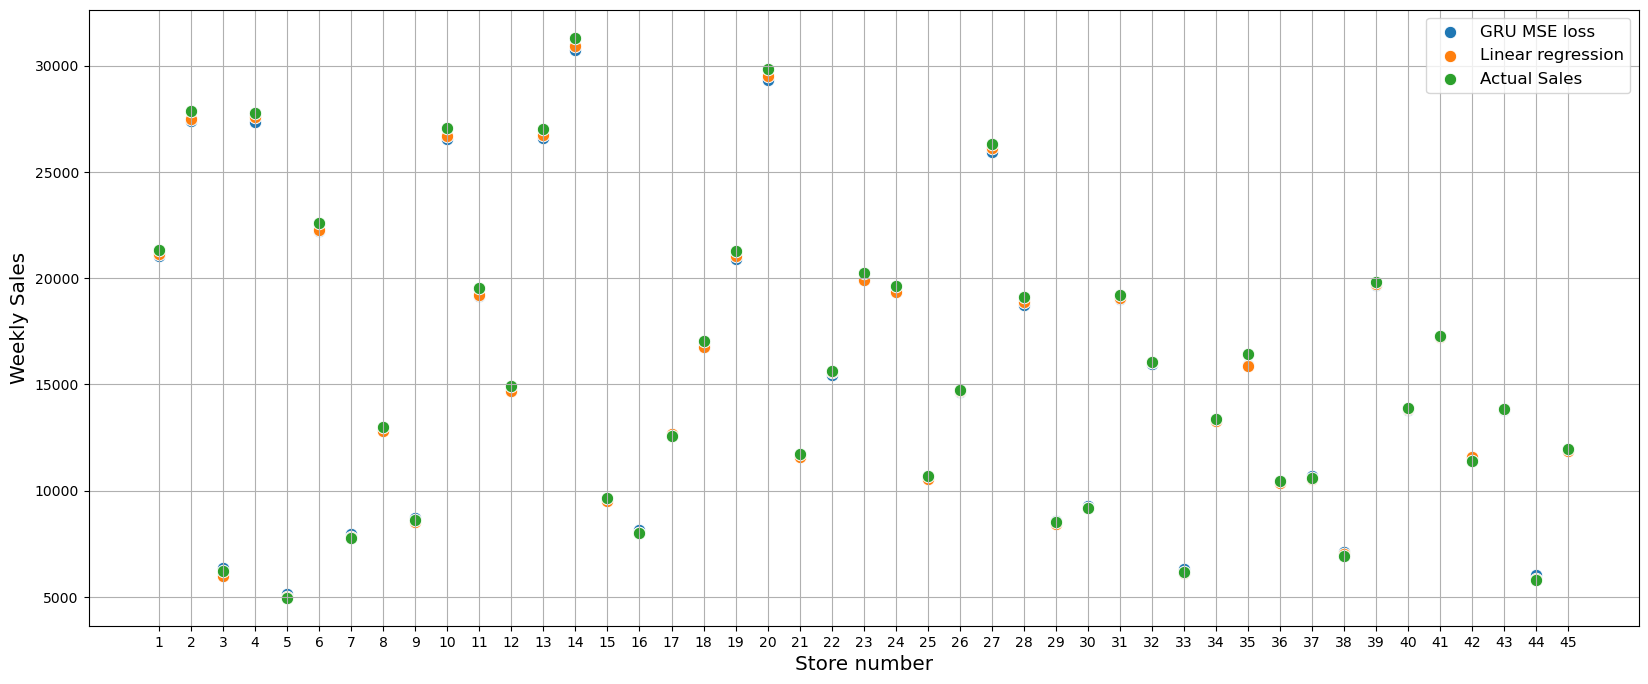

In [174]:
plt.figure(figsize=(20,8))
sns.scatterplot(x=vldt4_grouped.index, y=vldt4_grouped['y_vldt_pred'], label='GRU MSE loss',s=80)

sns.scatterplot(x=vldt1_grouped.index, y=vldt1_grouped['y_vldt_pred'], label='Linear regression',s=80)
sns.scatterplot(x=vldt3_grouped.index, y=vldt3_grouped['weeklySales'], label='Actual Sales',s=80)
plt.legend(fontsize='large') 
plt.xlabel('Store number',fontsize='x-large')
plt.ylabel('Weekly Sales',fontsize='x-large')
plt.xticks(np.arange(1, 46, step=1))
plt.grid()
plt

## Mult-feature RNN (GRU)

In [175]:

df1 = train.loc[:,  'ThanksGiving_Ind':'Chistmas_3_Ind']
#df2 = train.loc[:, 'Size_norm':'Size_norm']
#df3 = train.loc[:, 'Temperature_norm':'Unemployment_norm']
#df4 = train.loc[:, 'MarkDown1_Ind':'Holiday_Ind']
df5 = train.loc[:,'weeklySales_5':'weeklySales_1']
x_train = np.concatenate((df1, df5), axis=1)
y_train = train['weeklySales']

df1 = vldt.loc[:,  'ThanksGiving_Ind':'Chistmas_3_Ind']
#df2 = train.loc[:, 'Size_norm':'Size_norm']
#df3 = train.loc[:, 'Temperature_norm':'Unemployment_norm']
#df4 = train.loc[:, 'MarkDown1_Ind':'Holiday_Ind']
df5 = vldt.loc[:,'weeklySales_5':'weeklySales_1']
#df1 = vldt.loc[:, 'Store_1':'Type_C']
#df2 = vldt.loc[:, 'Size_norm':'Size_norm']
#df3 = vldt.loc[:, 'Temperature_norm':'Unemployment_norm']
#df4 = vldt.loc[:, 'MarkDown1_Ind':'Holiday_Ind']
#df5 = vldt.loc[:,'weeklySales_5':'weeklySales_1']
x_vldt = np.concatenate((df1, df2, df3, df4, df5), axis=1)
y_vldt = vldt['weeklySales']


y_train = np.array(y_train)
y_vldt = np.array(y_vldt)

x_train = torch.tensor(x_train).unsqueeze(2).float()
x_vldt = torch.tensor(x_vldt).unsqueeze(2).float()
y_train = torch.tensor(y_train).unsqueeze(1).float()
y_vldt = torch.tensor(y_vldt).unsqueeze(1).float()

print('x_train.shape = ', x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_vldt.shape = ', x_vldt.shape)
print('y_vldt.shape = ', y_vldt.shape)
# Check for NaN values
nan_mask = torch.isnan(x_train)
#print("NaN values:", nan_mask)
print(sum(nan_mask))

# Check for infinite values
inf_mask = torch.isinf(x_train)
#print("Infinite values:", inf_mask)
print(sum(inf_mask))

x_train.shape =  torch.Size([264748, 9, 1])
y_train.shape =  torch.Size([264748, 1])
x_vldt.shape =  torch.Size([140461, 20, 1])
y_vldt.shape =  torch.Size([140461, 1])
tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]])
tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]])


In [176]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True).to(device)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :])
        return out
    

In [177]:
input_dim = 1
hidden_dim = 64
num_layers = 1
output_dim = 1
num_epochs = 500
learning_rate = 0.01
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [178]:
model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers).to(device)
#criterion = torch.nn.MSELoss(reduction='mean')
criterion = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [179]:
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []
for t in range(num_epochs):
    x_train = x_train.to(device)
    y_train = y_train.to(device)
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.9719719290733337
Epoch  1 MSE:  0.449750691652298
Epoch  2 MSE:  0.07782219350337982
Epoch  3 MSE:  0.11243977397680283
Epoch  4 MSE:  0.09096341580152512
Epoch  5 MSE:  0.004273117519915104
Epoch  6 MSE:  0.020506426692008972
Epoch  7 MSE:  0.053352706134319305
Epoch  8 MSE:  0.058512747287750244
Epoch  9 MSE:  0.03947628289461136
Epoch  10 MSE:  0.014575299806892872
Epoch  11 MSE:  0.0017377554904669523
Epoch  12 MSE:  0.008168740198016167
Epoch  13 MSE:  0.022840281948447227
Epoch  14 MSE:  0.027316637337207794
Epoch  15 MSE:  0.01845751330256462
Epoch  16 MSE:  0.006918573286384344
Epoch  17 MSE:  0.0015974389389157295
Epoch  18 MSE:  0.0034030135720968246
Epoch  19 MSE:  0.00834326259791851
Epoch  20 MSE:  0.012075230479240417
Epoch  21 MSE:  0.012358302250504494
Epoch  22 MSE:  0.009438391774892807
Epoch  23 MSE:  0.005253790877759457
Epoch  24 MSE:  0.002146115992218256
Epoch  25 MSE:  0.001556761795654893
Epoch  26 MSE:  0.0032401697244495153
Epoch  27 MSE:  0.

Epoch  215 MSE:  0.0005336760659702122
Epoch  216 MSE:  0.0005290427943691611
Epoch  217 MSE:  0.0005244311760179698
Epoch  218 MSE:  0.0005198419094085693
Epoch  219 MSE:  0.0005152753437869251
Epoch  220 MSE:  0.0005107320612296462
Epoch  221 MSE:  0.00050621252739802
Epoch  222 MSE:  0.0005017172661609948
Epoch  223 MSE:  0.0004972467431798577
Epoch  224 MSE:  0.0004928014823235571
Epoch  225 MSE:  0.000488382123876363
Epoch  226 MSE:  0.00048398904618807137
Epoch  227 MSE:  0.0004796230641659349
Epoch  228 MSE:  0.00047528452705591917
Epoch  229 MSE:  0.0004709741042461246
Epoch  230 MSE:  0.00046669223229400814
Epoch  231 MSE:  0.0004624396387953311
Epoch  232 MSE:  0.0004582167894113809
Epoch  233 MSE:  0.0004540243826340884
Epoch  234 MSE:  0.0004498629132285714
Epoch  235 MSE:  0.00044573305058293045
Epoch  236 MSE:  0.00044163549318909645
Epoch  237 MSE:  0.0004375706485006958
Epoch  238 MSE:  0.00043353921500965953
Epoch  239 MSE:  0.0004295418912079185
Epoch  240 MSE:  0.000

Epoch  424 MSE:  0.0002548897755332291
Epoch  425 MSE:  0.00025488698156550527
Epoch  426 MSE:  0.0002548841875977814
Epoch  427 MSE:  0.0002548813936300576
Epoch  428 MSE:  0.0002548786287661642
Epoch  429 MSE:  0.00025487583479844034
Epoch  430 MSE:  0.0002548730408307165
Epoch  431 MSE:  0.0002548702177591622
Epoch  432 MSE:  0.0002548674528952688
Epoch  433 MSE:  0.0002548646880313754
Epoch  434 MSE:  0.00025486189406365156
Epoch  435 MSE:  0.00025485912919975817
Epoch  436 MSE:  0.0002548563352320343
Epoch  437 MSE:  0.00025485351216048
Epoch  438 MSE:  0.00025485074729658663
Epoch  439 MSE:  0.00025484798243269324
Epoch  440 MSE:  0.0002548451884649694
Epoch  441 MSE:  0.00025484245270490646
Epoch  442 MSE:  0.0002548396878410131
Epoch  443 MSE:  0.0002548369229771197
Epoch  444 MSE:  0.00025483412900939584
Epoch  445 MSE:  0.00025483136414550245
Epoch  446 MSE:  0.0002548286283854395
Epoch  447 MSE:  0.0002548258635215461
Epoch  448 MSE:  0.0002548231277614832
Epoch  449 MSE:  0

In [180]:
predict = scaler.inverse_transform(y_train_pred.detach().cpu().numpy())
original = scaler.inverse_transform(y_train.detach().cpu().numpy())

train7 = train.copy()
train7['y_pred'] = predict
train7['weeklySales'] = original
print(np.mean(np.absolute(train7['weeklySales']-train7['y_pred'])*train7['Holiday_loss']))

2824.940731507082


In [182]:
# make predictions
with torch.no_grad():
    x_vldt = x_vldt.to(device)
    y_vldt_pred = model(x_vldt)


predict_vldt = scaler.inverse_transform(y_vldt_pred.detach().cpu().numpy())
original_vldt = scaler.inverse_transform(y_vldt.detach().cpu().numpy())
vldt7 = vldt.copy()
vldt7['y_vldt_pred'] = predict_vldt
vldt7['weeklySales'] = original_vldt

print(np.mean(np.absolute(vldt7['weeklySales']-vldt7['y_vldt_pred'])*vldt7['Holiday_loss']))

17713.641039740625


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

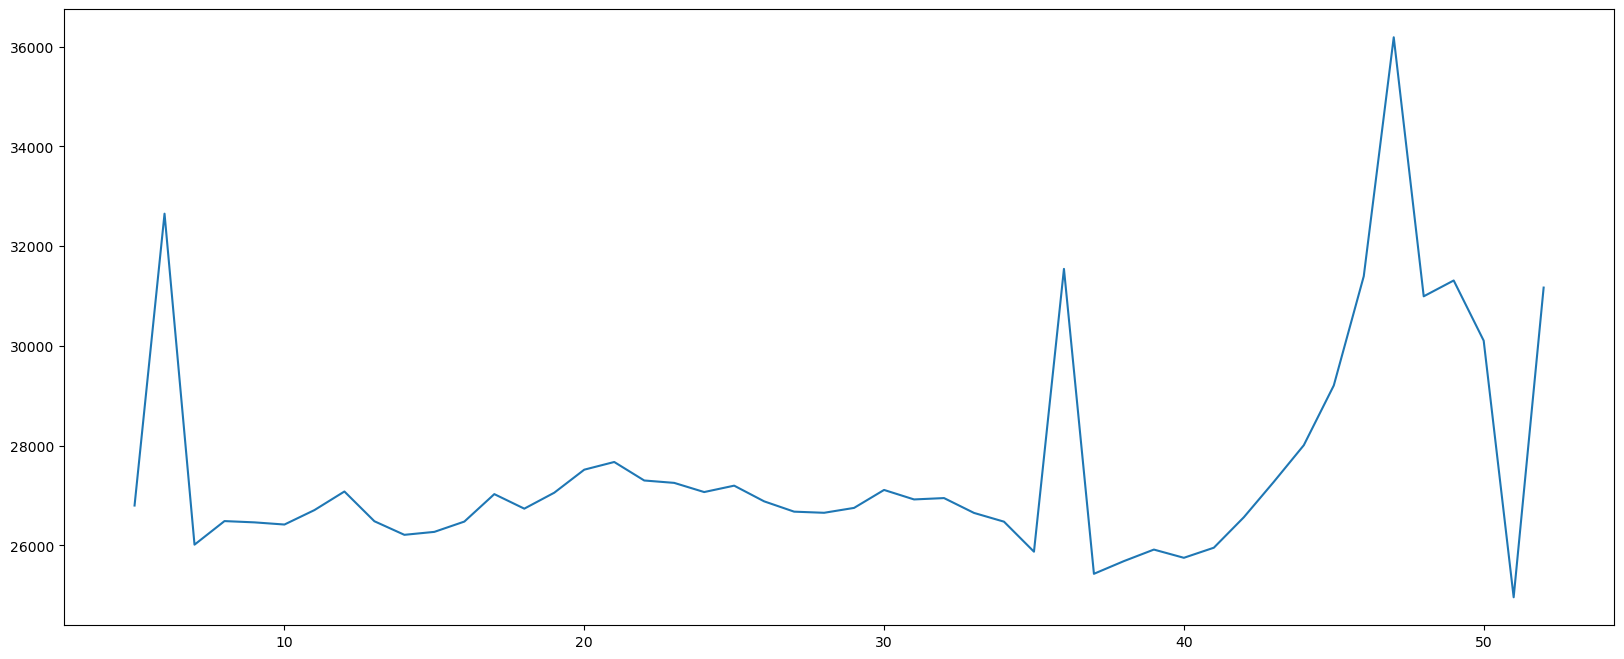

In [185]:
vldt7_grouped2 = vldt7.groupby(['Week'])[['weeklySales','y_vldt_pred']].mean()
train7_grouped2 = train7.groupby(['Week'])[['weeklySales','y_pred']].mean()
#print(vldt_grouped.head(5))
plt.figure(figsize=(20,8))
sns.lineplot(x=vldt7_grouped2.index, y=vldt7_grouped2['y_vldt_pred'], label='GRU MSE loss')

sns.lineplot(x=vldt1_grouped2.index, y=vldt1_grouped2['y_vldt_pred'], label='Linear regression 1')
sns.lineplot(x=vldt3_grouped2.index, y=vldt3_grouped2['weeklySales'], label='Actual Sales')
plt.legend(fontsize='large') 
plt.xlabel('Week',fontsize='x-large')
plt.ylabel('Weekly Sales',fontsize='x-large')
plt.xticks(np.arange(1, 53, step=1))
plt.grid()
plt